In [1]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

2.3.0


In [2]:
from constants import *;
from NN_predict_v1 import *;

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

### The goal of this file:
Try to set up the environment so that all the zip codes are fed into the data

#### Reading the zri csv file

In [4]:
multi_data = pd.read_csv('../data/zri_multifamily_v2.csv');
# multi_data = multi_data[multi_data["State"] == "NY"];
multi_data.head()

zip      City State        Metro      CountyName year-month    zri
0  1013  Chicopee    MA  Springfield  Hampden County    2014-01  928.0
1  1013  Chicopee    MA  Springfield  Hampden County    2014-02  931.0
2  1013  Chicopee    MA  Springfield  Hampden County    2014-03  934.0
3  1013  Chicopee    MA  Springfield  Hampden County    2014-04  929.0
4  1013  Chicopee    MA  Springfield  Hampden County    2014-05  929.0

In [5]:
# df = multi_data[multi_data["year-month"]=="2014-01"];
# temp = df.groupby("State")["zip"].count();
# temp = pd.DataFrame({"State": temp.index, "num_zip": temp});
# temp.reset_index(drop = True, inplace = True);

In [6]:
# temp.sort_values("num_zip", ascending = False, inplace = True);
# print(df[df["State"].isin(zone_dict["zone_6"])].shape[0])

zone_dict = {
    "zone_1": ["MA", "CT", "RI", "DC", "NJ", "ME", "NH"],
    "zone_2": ["NY"],
    "zone_3": ["FL", "GA", "NC", "TN", "SC", "KY", "MO", "AR"],
    "zone_4": ["CA", "WA", "OR", "AK", "HI"],
    "zone_5": ["TX", "CO", "AZ", "KS", "UT", "NV", "MT", "OK", "ND", "NM"],
    "zone_6": ["IL", "PA", "VA", "OH", "WI", "MD", "MN", "IN", "MI", "WV", "IA"]
};

In [7]:
# In our first try, just look at the zip codes in NY.
multi_4 = multi_data[multi_data["State"].isin(zone_dict["zone_4"])]["zip"].unique();
print(len(multi_4))

242


#### Segmenting the csv file into tens of thousands of windows

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
# test_NY = multi_data[multi_data["zip"] == 10001];

# single_city_series = np.array(test_NY["zri"])

In [10]:
cities_stats = {};
dataset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);
validset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);

dataset_created = False;
#for zip_num in multi_data["zip"].unique():
for zip_num in multi_4:
    test = multi_data[multi_data["zip"] == zip_num];
    single_city_series = np.array(test["zri"]);
    
    single_city_series_mean = single_city_series.mean();
    single_city_series_std = single_city_series.std();
    single_city_series = (single_city_series - single_city_series_mean)/\
    single_city_series_std;
    
    cities_stats[zip_num] = {"mean": single_city_series_mean,
                             "std":single_city_series_std};
    
    single_city_train = single_city_series[:SPLIT];
    single_city_test = single_city_series[SPLIT-WINDOW_SIZE:];
    
    cityset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60);
    cityvalid = windowed_dataset(single_city_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
    dataset = dataset.concatenate(cityset);
    validset = validset.concatenate(cityvalid);

In [11]:
# i = 0
# for x,y in dataset:
#     print("x = ", x.numpy())
#     print("y = ", y.numpy())
# i

In [12]:
# Concatenate tensorflow dataset
# cities_stats

#### Messing up with the Tensorflow models

In [13]:
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
#   tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 2.0)
])

model.summary();

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./tensorflow_ckpt/{epoch:03d}_{mse:.4f}_{val_mse:.4f}",\
#                                                  save_best_only=False,\
#                                                  save_weights_only=False, verbose=1,\
#                                                  save_freq="epoch");

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "mse"])
# history = model.fit(dataset, epochs=10, validation_data=validset,\
#                     callbacks=[cp_callback])
with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
    history = model.fit(dataset, epochs=500, validation_data=validset);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 18,017
Trainable params: 18,017
Non-trainable params: 0
____________________________________________________

Epoch 43/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0043 - mae: 0.0685 - mse: 0.0086 - val_loss: 0.0093 - val_mae: 0.0917 - val_mse: 0.0186
Epoch 44/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0043 - mae: 0.0684 - mse: 0.0085 - val_loss: 0.0092 - val_mae: 0.0916 - val_mse: 0.0185
Epoch 45/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0043 - mae: 0.0683 - mse: 0.0085 - val_loss: 0.0093 - val_mae: 0.0917 - val_mse: 0.0186
Epoch 46/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0043 - mae: 0.0686 - mse: 0.0086 - val_loss: 0.0099 - val_mae: 0.0979 - val_mse: 0.0198
Epoch 47/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0043 - mae: 0.0684 - mse: 0.0085 - val_loss: 0.0102 - val_mae: 0.1009 - val_mse: 0.0204
Epoch 48/500
484/484 [==============================] - 20s 40ms/step - loss: 0.0042 - mae: 0.0682 - mse: 0.0085 - val_loss: 0.0101 - val_mae: 0.0995 - val_mse:

484/484 [==============================] - 20s 41ms/step - loss: 0.0038 - mae: 0.0654 - mse: 0.0076 - val_loss: 0.0107 - val_mae: 0.1037 - val_mse: 0.0213
Epoch 92/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0038 - mae: 0.0653 - mse: 0.0076 - val_loss: 0.0106 - val_mae: 0.1032 - val_mse: 0.0211
Epoch 93/500
484/484 [==============================] - 19s 40ms/step - loss: 0.0038 - mae: 0.0650 - mse: 0.0076 - val_loss: 0.0100 - val_mae: 0.0979 - val_mse: 0.0199
Epoch 94/500
484/484 [==============================] - 19s 40ms/step - loss: 0.0038 - mae: 0.0651 - mse: 0.0076 - val_loss: 0.0113 - val_mae: 0.1090 - val_mse: 0.0225
Epoch 95/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0038 - mae: 0.0653 - mse: 0.0076 - val_loss: 0.0111 - val_mae: 0.1073 - val_mse: 0.0223
Epoch 96/500
484/484 [==============================] - 20s 40ms/step - loss: 0.0038 - mae: 0.0654 - mse: 0.0076 - val_loss: 0.0112 - val_mae: 0.1080 - val_mse: 0.0223
Epoch

484/484 [==============================] - 19s 38ms/step - loss: 0.0032 - mae: 0.0607 - mse: 0.0065 - val_loss: 0.0111 - val_mae: 0.1035 - val_mse: 0.0222
Epoch 140/500
484/484 [==============================] - 21s 43ms/step - loss: 0.0032 - mae: 0.0604 - mse: 0.0064 - val_loss: 0.0109 - val_mae: 0.1023 - val_mse: 0.0219
Epoch 141/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0032 - mae: 0.0604 - mse: 0.0064 - val_loss: 0.0128 - val_mae: 0.1176 - val_mse: 0.0256
Epoch 142/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0032 - mae: 0.0607 - mse: 0.0065 - val_loss: 0.0112 - val_mae: 0.1048 - val_mse: 0.0225
Epoch 143/500
484/484 [==============================] - 20s 40ms/step - loss: 0.0032 - mae: 0.0602 - mse: 0.0064 - val_loss: 0.0114 - val_mae: 0.1062 - val_mse: 0.0227
Epoch 144/500
484/484 [==============================] - 20s 42ms/step - loss: 0.0032 - mae: 0.0602 - mse: 0.0064 - val_loss: 0.0108 - val_mae: 0.1023 - val_mse: 0.0217


484/484 [==============================] - 19s 39ms/step - loss: 0.0028 - mae: 0.0561 - mse: 0.0055 - val_loss: 0.0115 - val_mae: 0.1042 - val_mse: 0.0229
Epoch 188/500
484/484 [==============================] - 18s 38ms/step - loss: 0.0028 - mae: 0.0564 - mse: 0.0056 - val_loss: 0.0115 - val_mae: 0.1048 - val_mse: 0.0231
Epoch 189/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0027 - mae: 0.0559 - mse: 0.0055 - val_loss: 0.0117 - val_mae: 0.1055 - val_mse: 0.0234
Epoch 190/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0028 - mae: 0.0566 - mse: 0.0056 - val_loss: 0.0111 - val_mae: 0.1030 - val_mse: 0.0222
Epoch 191/500
484/484 [==============================] - 19s 40ms/step - loss: 0.0027 - mae: 0.0558 - mse: 0.0055 - val_loss: 0.0118 - val_mae: 0.1067 - val_mse: 0.0237
Epoch 192/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0028 - mae: 0.0561 - mse: 0.0055 - val_loss: 0.0119 - val_mae: 0.1083 - val_mse: 0.0237


484/484 [==============================] - 19s 39ms/step - loss: 0.0024 - mae: 0.0521 - mse: 0.0048 - val_loss: 0.0117 - val_mae: 0.1064 - val_mse: 0.0234
Epoch 236/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0024 - mae: 0.0521 - mse: 0.0048 - val_loss: 0.0121 - val_mae: 0.1093 - val_mse: 0.0243
Epoch 237/500
484/484 [==============================] - 19s 40ms/step - loss: 0.0024 - mae: 0.0517 - mse: 0.0047 - val_loss: 0.0119 - val_mae: 0.1080 - val_mse: 0.0238
Epoch 238/500
484/484 [==============================] - 20s 40ms/step - loss: 0.0023 - mae: 0.0511 - mse: 0.0046 - val_loss: 0.0119 - val_mae: 0.1078 - val_mse: 0.0238
Epoch 239/500
484/484 [==============================] - 19s 40ms/step - loss: 0.0023 - mae: 0.0514 - mse: 0.0047 - val_loss: 0.0117 - val_mae: 0.1072 - val_mse: 0.0233
Epoch 240/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0023 - mae: 0.0510 - mse: 0.0046 - val_loss: 0.0121 - val_mae: 0.1089 - val_mse: 0.0243


484/484 [==============================] - 20s 42ms/step - loss: 0.0020 - mae: 0.0477 - mse: 0.0040 - val_loss: 0.0128 - val_mae: 0.1130 - val_mse: 0.0256
Epoch 284/500
484/484 [==============================] - 20s 42ms/step - loss: 0.0021 - mae: 0.0485 - mse: 0.0041 - val_loss: 0.0127 - val_mae: 0.1138 - val_mse: 0.0254
Epoch 285/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0020 - mae: 0.0474 - mse: 0.0039 - val_loss: 0.0132 - val_mae: 0.1168 - val_mse: 0.0264
Epoch 286/500
484/484 [==============================] - 19s 40ms/step - loss: 0.0020 - mae: 0.0476 - mse: 0.0040 - val_loss: 0.0129 - val_mae: 0.1148 - val_mse: 0.0258
Epoch 287/500
484/484 [==============================] - 20s 42ms/step - loss: 0.0020 - mae: 0.0480 - mse: 0.0040 - val_loss: 0.0127 - val_mae: 0.1136 - val_mse: 0.0255
Epoch 288/500
484/484 [==============================] - 20s 41ms/step - loss: 0.0020 - mae: 0.0483 - mse: 0.0041 - val_loss: 0.0127 - val_mae: 0.1127 - val_mse: 0.0255


484/484 [==============================] - 19s 40ms/step - loss: 0.0017 - mae: 0.0445 - mse: 0.0035 - val_loss: 0.0130 - val_mae: 0.1143 - val_mse: 0.0259
Epoch 332/500
484/484 [==============================] - 19s 38ms/step - loss: 0.0017 - mae: 0.0443 - mse: 0.0034 - val_loss: 0.0132 - val_mae: 0.1158 - val_mse: 0.0264
Epoch 333/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0017 - mae: 0.0441 - mse: 0.0034 - val_loss: 0.0132 - val_mae: 0.1164 - val_mse: 0.0264
Epoch 334/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0018 - mae: 0.0450 - mse: 0.0035 - val_loss: 0.0136 - val_mae: 0.1170 - val_mse: 0.0272
Epoch 335/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0018 - mae: 0.0454 - mse: 0.0036 - val_loss: 0.0129 - val_mae: 0.1137 - val_mse: 0.0258
Epoch 336/500
484/484 [==============================] - 19s 39ms/step - loss: 0.0018 - mae: 0.0449 - mse: 0.0035 - val_loss: 0.0130 - val_mae: 0.1142 - val_mse: 0.0261


484/484 [==============================] - 17s 35ms/step - loss: 0.0016 - mae: 0.0428 - mse: 0.0032 - val_loss: 0.0137 - val_mae: 0.1195 - val_mse: 0.0274s: 0.0018 - mae - ETA: 1s - loss: 0.0017 - mae:
Epoch 379/500
484/484 [==============================] - 16s 33ms/step - loss: 0.0016 - mae: 0.0429 - mse: 0.0032 - val_loss: 0.0138 - val_mae: 0.1202 - val_mse: 0.0277
Epoch 380/500
484/484 [==============================] - 16s 34ms/step - loss: 0.0016 - mae: 0.0430 - mse: 0.0032 - val_loss: 0.0135 - val_mae: 0.1181 - val_mse: 0.0269
Epoch 381/500
484/484 [==============================] - 17s 35ms/step - loss: 0.0017 - mae: 0.0441 - mse: 0.0033 - val_loss: 0.0140 - val_mae: 0.1205 - val_mse: 0.0279
Epoch 382/500
484/484 [==============================] - 17s 36ms/step - loss: 0.0016 - mae: 0.0433 - mse: 0.0032 - val_loss: 0.0140 - val_mae: 0.1218 - val_mse: 0.0280
Epoch 383/500
484/484 [==============================] - 17s 35ms/step - loss: 0.0016 - mae: 0.0438 - mse: 0.0033 - val_lo

484/484 [==============================] - 15s 31ms/step - loss: 0.0014 - mae: 0.0406 - mse: 0.0028 - val_loss: 0.0145 - val_mae: 0.1247 - val_mse: 0.0291
Epoch 427/500
484/484 [==============================] - 15s 31ms/step - loss: 0.0014 - mae: 0.0410 - mse: 0.0029 - val_loss: 0.0144 - val_mae: 0.1223 - val_mse: 0.0287
Epoch 428/500
484/484 [==============================] - 15s 30ms/step - loss: 0.0014 - mae: 0.0405 - mse: 0.0028 - val_loss: 0.0141 - val_mae: 0.1217 - val_mse: 0.0282
Epoch 429/500
484/484 [==============================] - 15s 31ms/step - loss: 0.0014 - mae: 0.0396 - mse: 0.0027 - val_loss: 0.0141 - val_mae: 0.1212 - val_mse: 0.0282
Epoch 430/500
484/484 [==============================] - 15s 31ms/step - loss: 0.0014 - mae: 0.0401 - mse: 0.0028 - val_loss: 0.0144 - val_mae: 0.1237 - val_mse: 0.0287
Epoch 431/500
484/484 [==============================] - 15s 32ms/step - loss: 0.0014 - mae: 0.0409 - mse: 0.0029 - val_loss: 0.0141 - val_mae: 0.1213 - val_mse: 0.0282


484/484 [==============================] - 14s 29ms/step - loss: 0.0013 - mae: 0.0392 - mse: 0.0027 - val_loss: 0.0139 - val_mae: 0.1212 - val_mse: 0.0279
Epoch 475/500
484/484 [==============================] - 14s 30ms/step - loss: 0.0014 - mae: 0.0397 - mse: 0.0027 - val_loss: 0.0141 - val_mae: 0.1219 - val_mse: 0.0283
Epoch 476/500
484/484 [==============================] - 14s 30ms/step - loss: 0.0013 - mae: 0.0386 - mse: 0.0026 - val_loss: 0.0141 - val_mae: 0.1208 - val_mse: 0.0281
Epoch 477/500
484/484 [==============================] - 15s 30ms/step - loss: 0.0013 - mae: 0.0387 - mse: 0.0026 - val_loss: 0.0152 - val_mae: 0.1283 - val_mse: 0.0304
Epoch 478/500
484/484 [==============================] - 14s 29ms/step - loss: 0.0013 - mae: 0.0383 - mse: 0.0025 - val_loss: 0.0144 - val_mae: 0.1232 - val_mse: 0.0288
Epoch 479/500
484/484 [==============================] - 14s 29ms/step - loss: 0.0013 - mae: 0.0394 - mse: 0.0027 - val_loss: 0.0144 - val_mae: 0.1229 - val_mse: 0.0288


#### Prediction, checking results

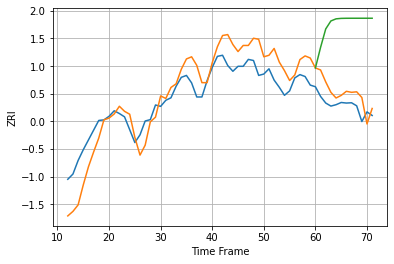

90001 74.76914613664808 57.25521179686304 297.12985769019014


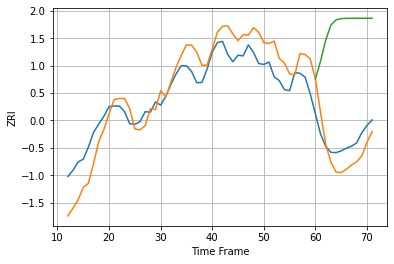

90002 71.8797195273495 67.39452114961364 382.5131553248344


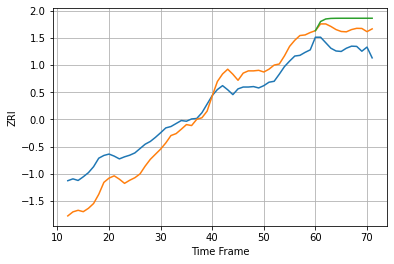

90003 87.68594869270542 83.14208471202404 124.96995646753712


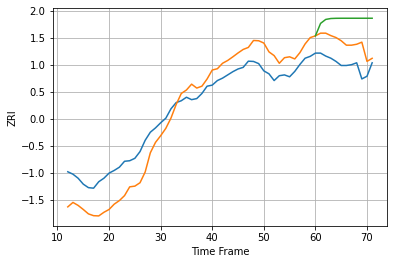

90004 81.78340050282749 80.58045364033669 164.8054136574858


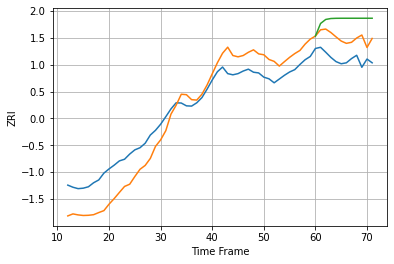

90006 90.14826359682648 90.62703923011044 166.02110892688407


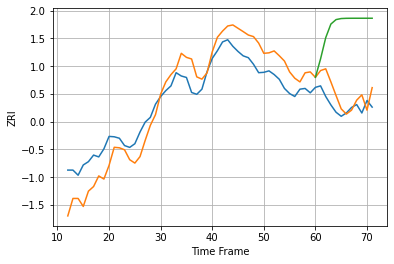

90007 58.491860253092796 41.67121446309707 218.74808058787144


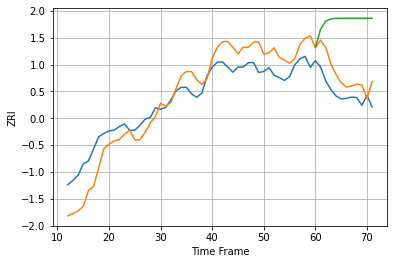

90011 77.7285907259704 79.0722011500545 282.8566932975811


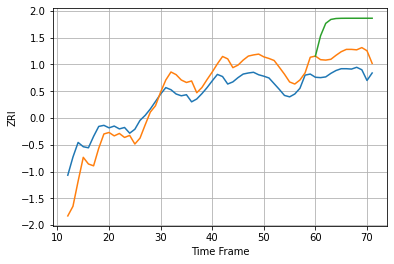

90012 50.78160101673309 53.177057849365866 141.03742968841453


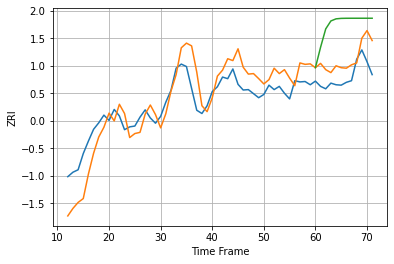

90015 50.42034257501831 48.247488527559305 130.9365454785887


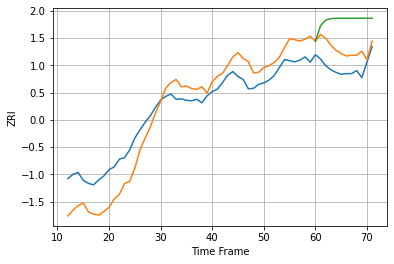

90016 87.73464057703369 79.32391263236853 190.79276867894956


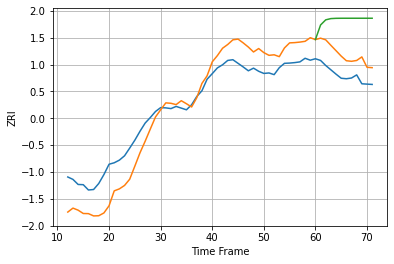

90018 88.00441547633953 86.93594291726504 229.02812447245486


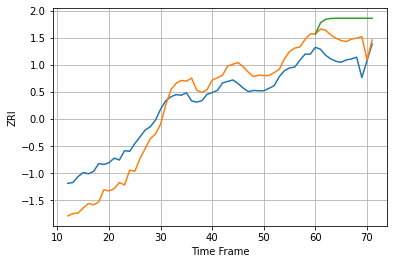

90019 69.25647718207524 71.93558776437368 131.0328722658361


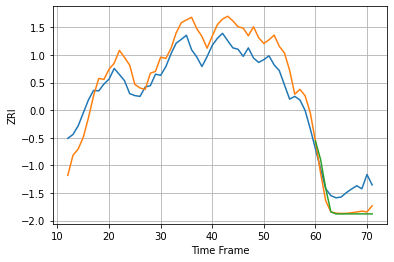

90022 72.64371658959428 74.48760508818535 80.44820876361969


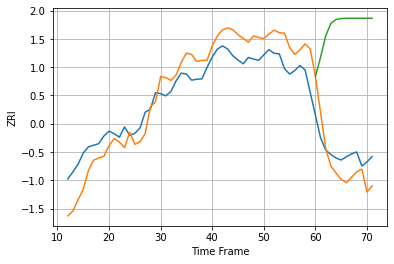

90023 66.72056990339267 71.48978436600603 397.29190197552873


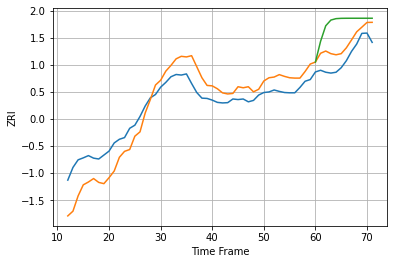

90024 66.81244464878634 53.40429178397899 128.8620319464299


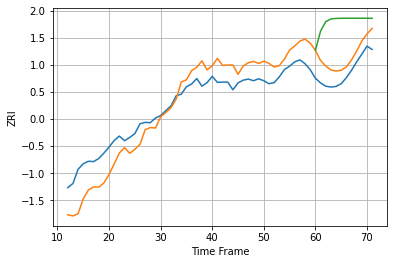

90025 72.01502406664298 62.35179490584769 189.49110051626207


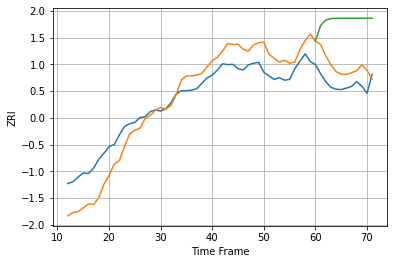

90026 71.75188569555401 69.44137856738193 224.39446348479535


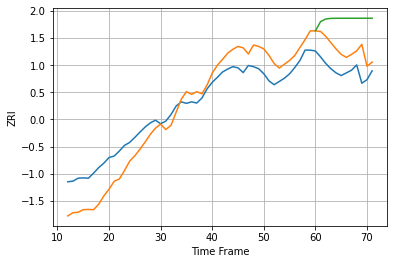

90027 69.4672058786433 75.22427673364729 171.94177313673694


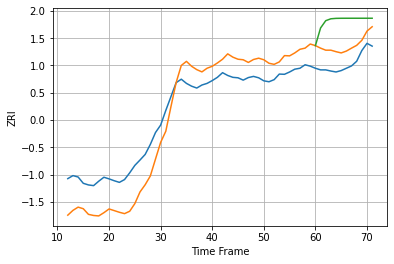

90028 103.10538846219501 78.66160970414555 184.2951621951137


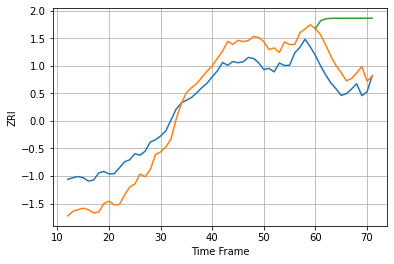

90029 90.94960880162826 86.11618864042623 256.64805296551816


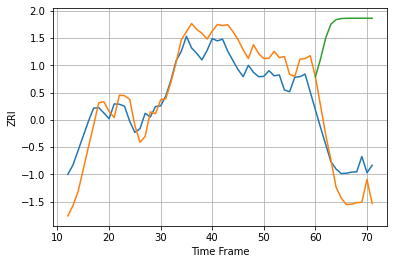

90031 73.49655250123504 97.14696080333785 474.69390399841797


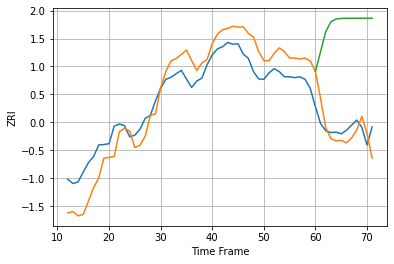

90032 50.300263104842145 40.77019706516184 241.53866556453642


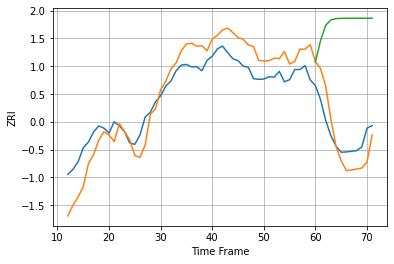

90033 65.78905913756435 69.33542117381005 357.4352160832177


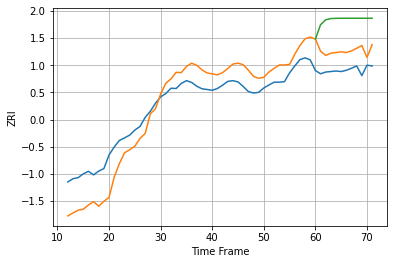

90034 81.68728748301132 82.12424099344419 196.77195348946893


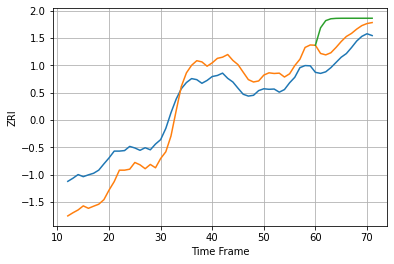

90035 83.0381747096208 61.973336909057714 134.56804913593635


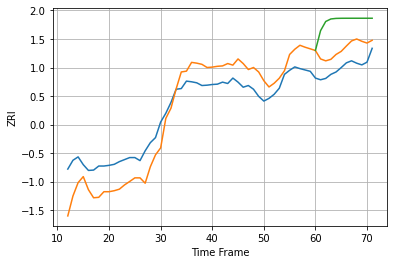

90036 63.94546263299643 57.56144702435135 136.59748471385421


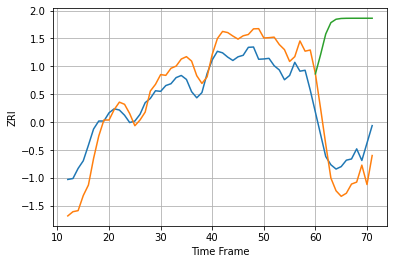

90037 70.06916472870604 91.01591756865514 413.3318480629311


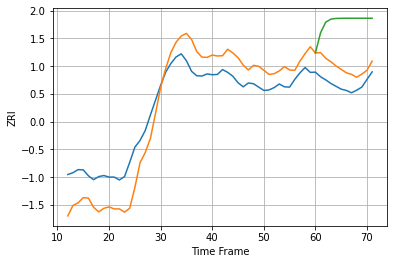

90038 93.94987867457465 69.75789428628441 241.92315152675005


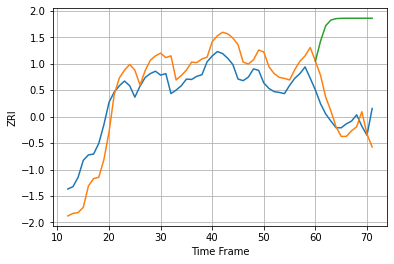

90039 55.401575388754445 47.559540782472254 245.18055227567967


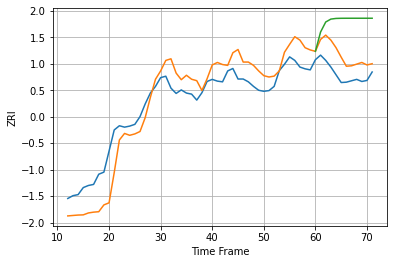

90041 58.5660903379546 54.73249143801298 151.8859368373997


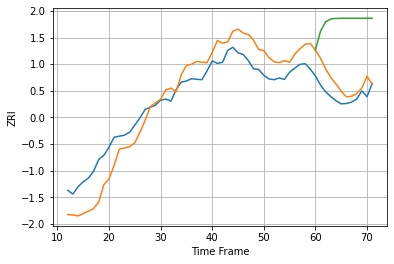

90042 60.29406435255376 48.34081940145484 216.51177120236233


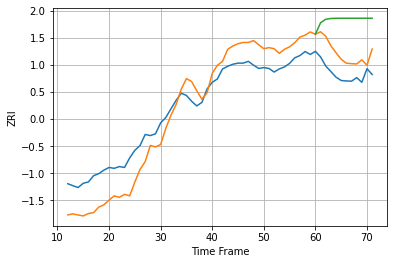

90043 100.63089972667721 96.04348223224927 242.44997007880633


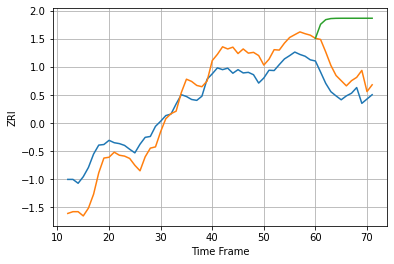

90044 68.81047765259505 72.6622905416225 238.95249071948936


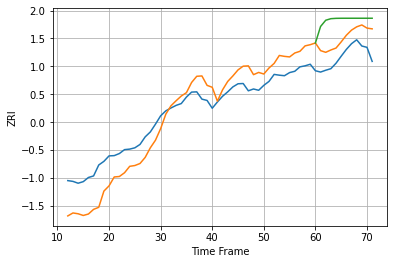

90045 78.97333043970114 76.53014350885604 144.00205530327628


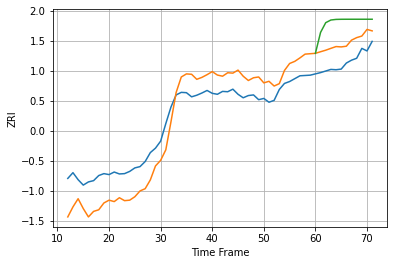

90046 70.88404001901282 61.43919399924021 125.81961071882833


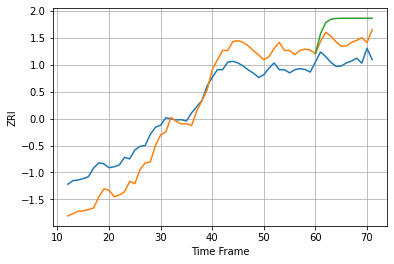

90047 84.63567652872996 77.98127430811891 148.33777526896563


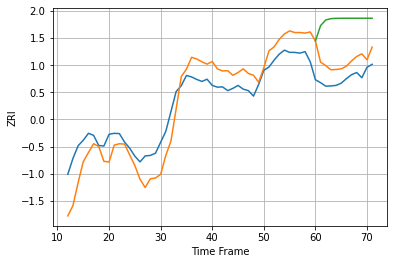

90048 83.95329758876028 78.7031588542712 233.15956134488314


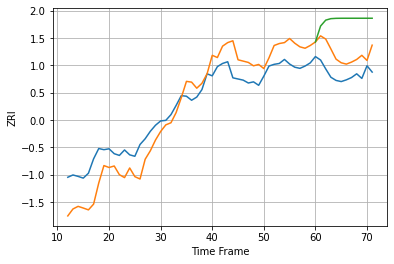

90061 75.3198326090546 72.94768818743215 185.82575763652306


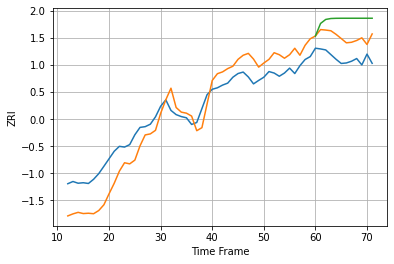

90062 83.70564593318528 87.16985615106417 156.26143926886778


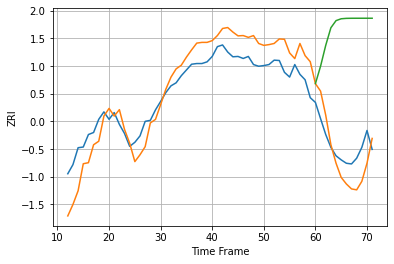

90063 62.48212068786707 67.52482876197593 354.00766570246043


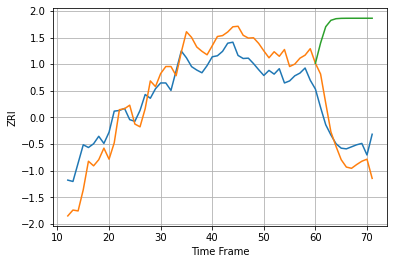

90065 63.71195990390783 65.07045119238332 337.19759362762585


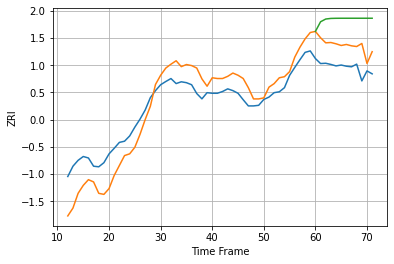

90066 66.00216777015933 78.16111105346535 162.96584904003672


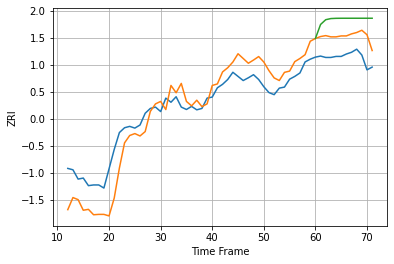

90068 59.100048439546406 62.116917925551896 109.20809575155792


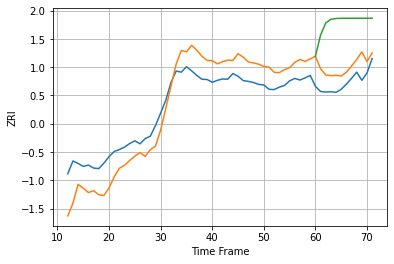

90069 77.43081877381414 65.88261933124855 222.09924959611723


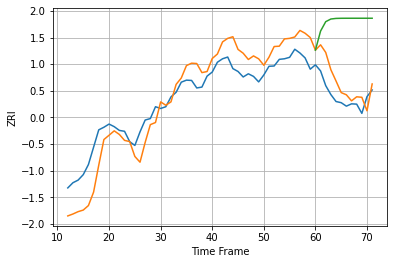

90220 71.58631218077203 61.78024383062735 261.3438290545695


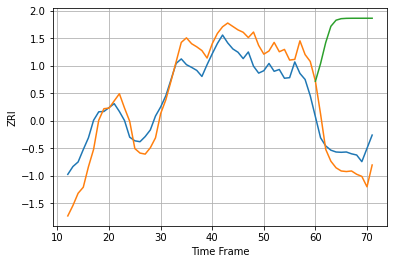

90221 71.49292807150017 75.19919676746399 398.62385690780917


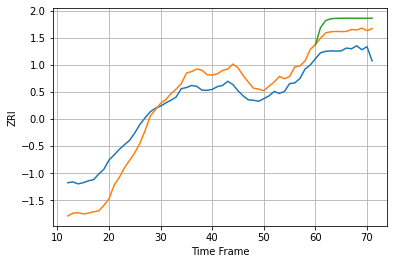

90232 86.46297772021211 83.82370553905082 131.35056785243458


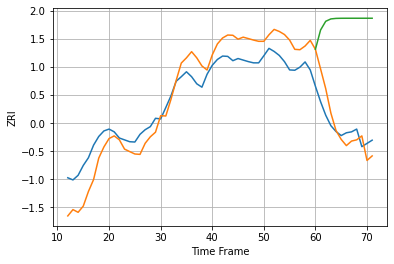

90247 68.06520669819312 61.6840649456937 348.8521953568954


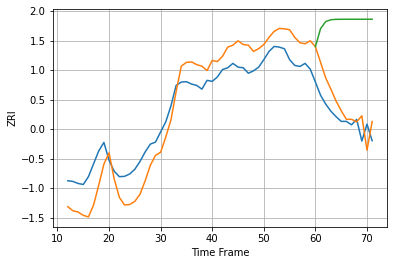

90250 69.05647101590262 63.66948353323029 286.012987187159


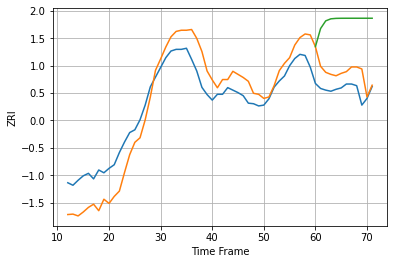

90254 81.59945833824605 73.21693767158679 247.87616471360352


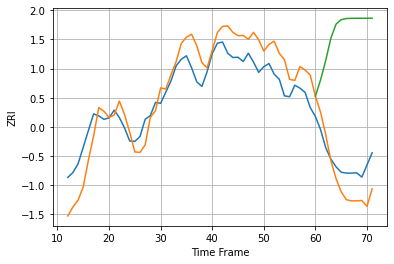

90255 77.62668425711047 85.79712050106791 457.231013645334


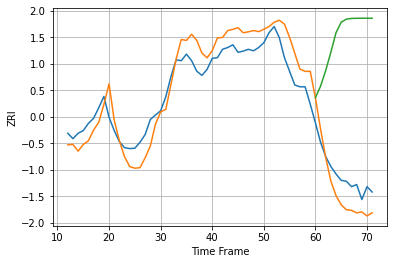

90260 62.790790114386134 72.62324579580883 474.52277107977864


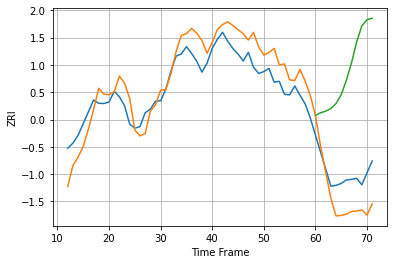

90262 72.13992674901708 106.84504449069034 394.5910304887899


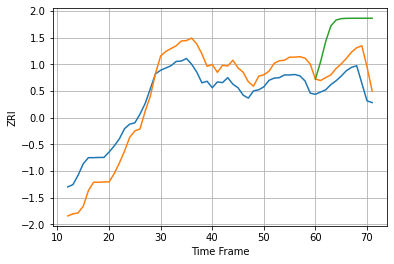

90266 94.68893266226983 84.29041234149736 255.25677717257804


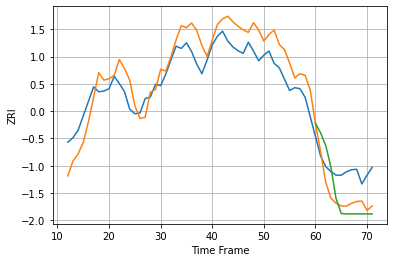

90270 79.41872912523202 107.42261286410992 129.72912652465493


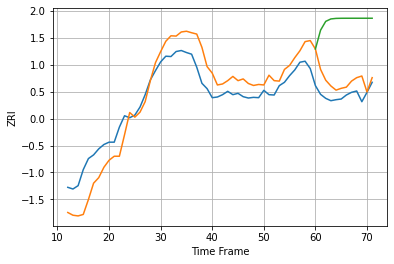

90277 60.67848482221874 52.924132516545015 219.05576159739923


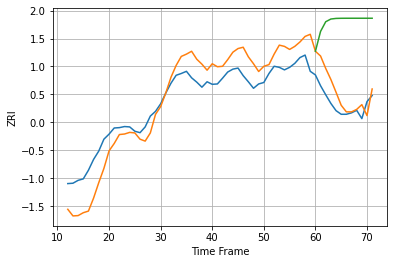

90278 57.830443715939396 47.77587457101659 230.84687995023575


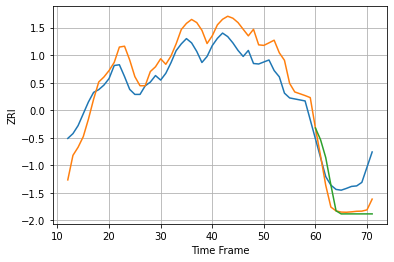

90280 78.6917038475241 104.9182501016365 120.55311860893619


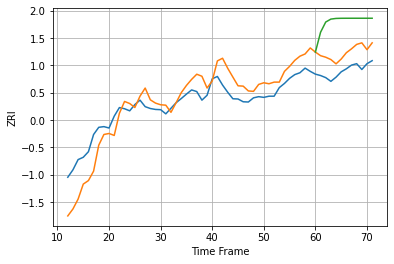

90291 76.1548241987622 80.89127781772777 211.54660982273938


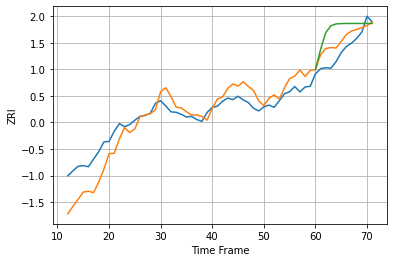

90292 71.95499197310484 54.18053248160512 106.5525725363233


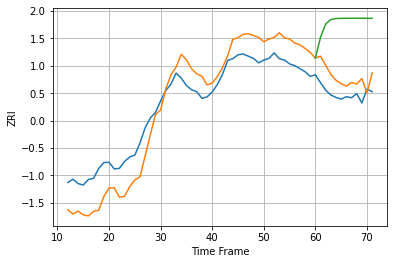

90301 84.71287798686966 65.39649444699162 257.34720650384776


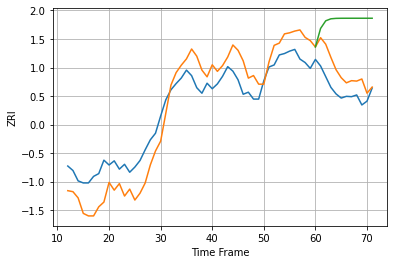

90302 68.26741497578334 60.789518743597526 202.9700160906432


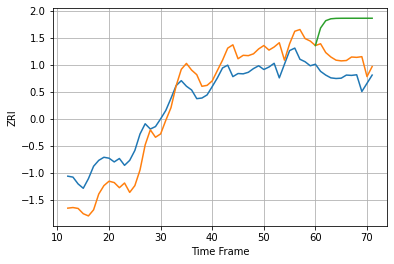

90303 72.7760388380131 64.99211617275833 182.42276879783282


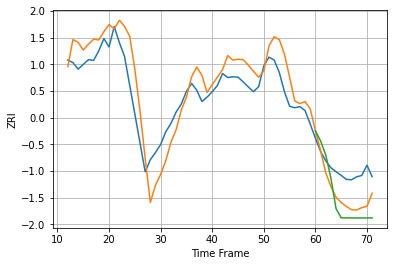

90304 60.92917919601018 69.3917678677781 95.13466021875817


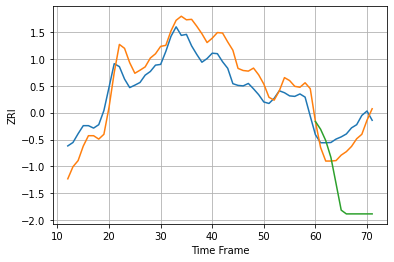

90404 77.7438875876884 65.88319986887787 286.6747644285029


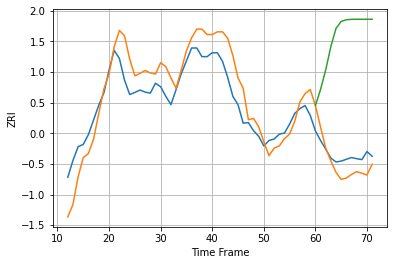

90405 74.11891698596892 51.97096502946175 402.84495036039107


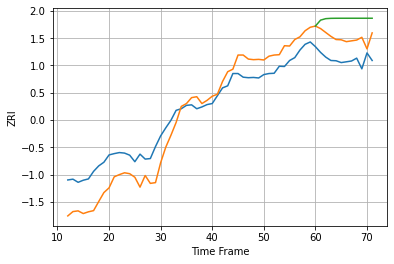

90501 81.71831330134357 86.17645866239567 153.98022337674905


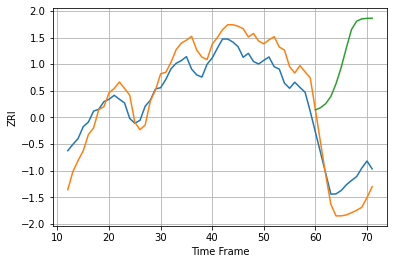

90640 63.351120757879734 85.51543542083375 397.21657297258025


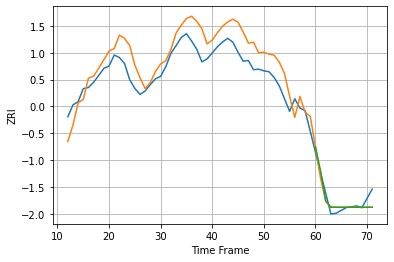

90723 79.97039847390651 31.680928752880916 30.472916918752706


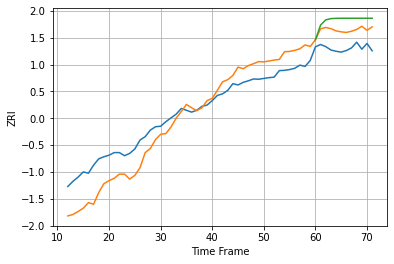

90731 75.49456355593186 69.76570370940819 107.78442789342971


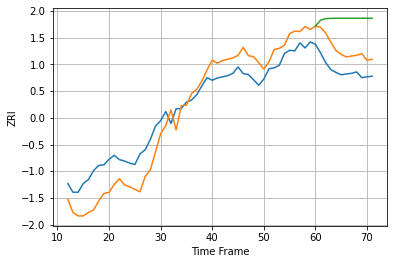

90744 73.85488479172017 74.20474480398337 177.4381852205554


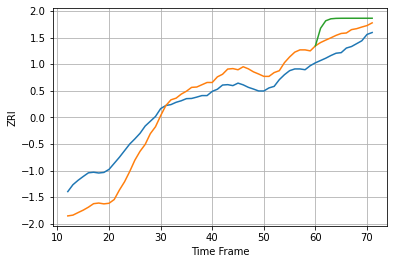

90802 105.46184440888462 83.0105907466755 148.97417165388558


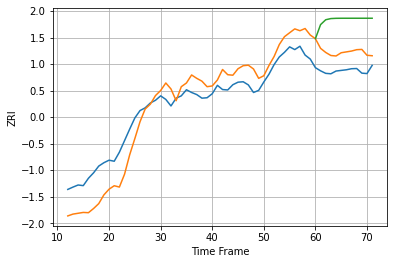

90803 96.21955439834673 93.44235490007028 239.4758475090087


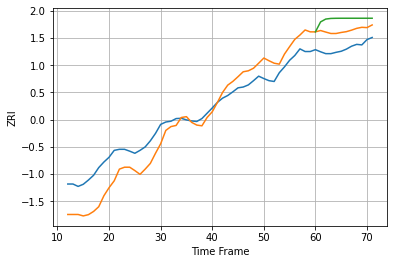

90804 74.19031970968544 66.97243900396847 108.12042248805952


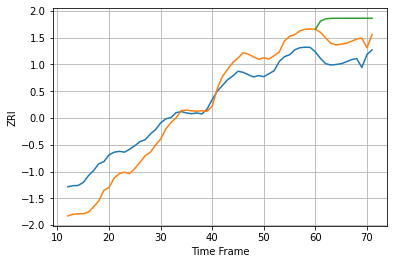

90805 72.45180278060431 77.66375033312326 151.89774643656108


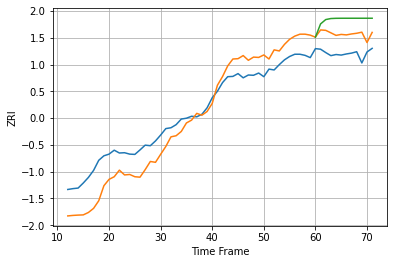

90806 72.72475701553797 70.33358504561156 119.8233160290186


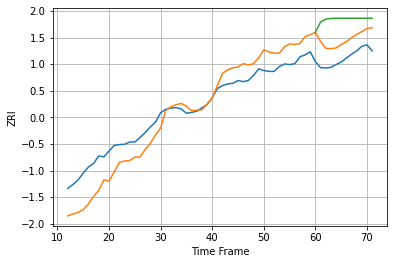

90807 66.49764759787563 69.60209335728011 137.11797785730897


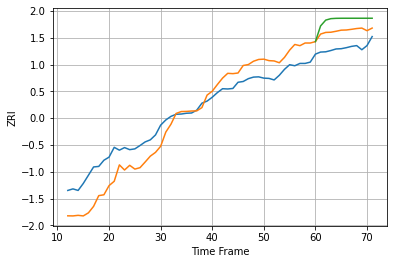

90813 75.96860161767343 66.20494622155803 107.29047219791359


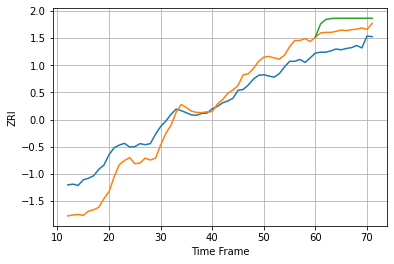

90814 72.8083981008685 64.41154981955538 103.0463318693764


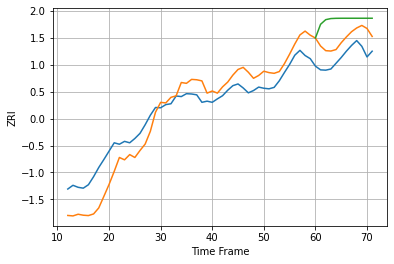

90815 67.34715874927541 67.30901317925444 131.94673600243323


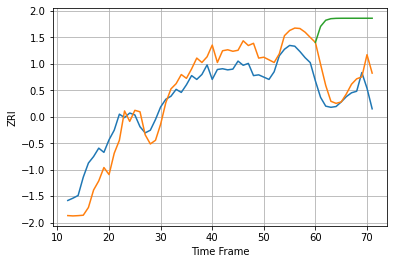

91016 53.093268594432 57.09167395088889 199.45305737641894


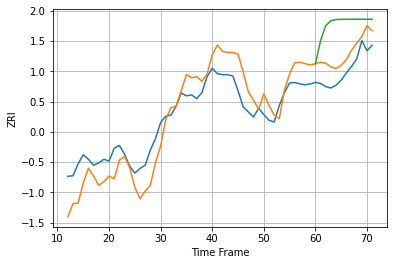

91101 45.97825305962751 38.90978728873091 103.64543075749522


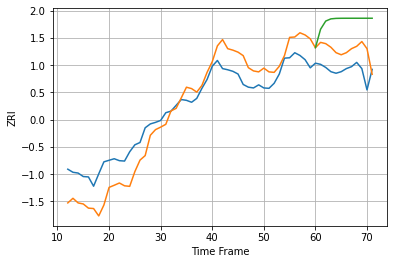

91104 56.00479597348679 57.233228951733274 127.91268029698483


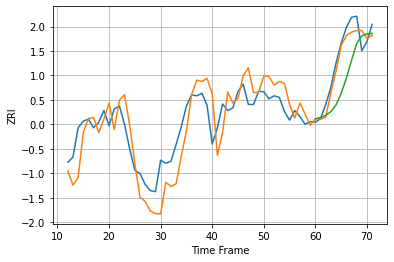

91105 44.68585189328395 20.64474771453152 58.53911999965718


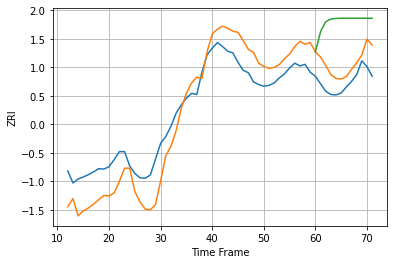

91106 61.18763797491984 51.522396827870544 153.90632212369766


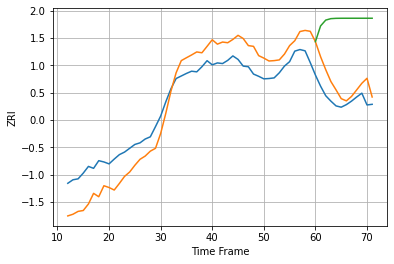

91107 70.57794750305023 59.59937334308419 246.4601451849637


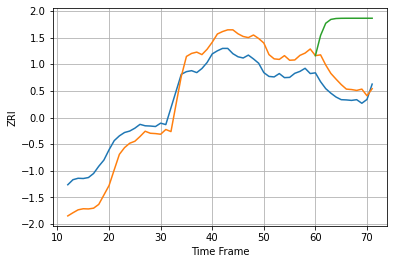

91205 90.0771075230898 66.74588524120739 302.7654965771243


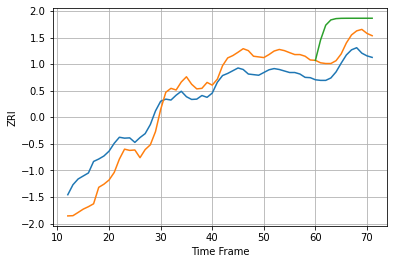

91355 66.61096646454611 57.10380031290229 137.17075336992642


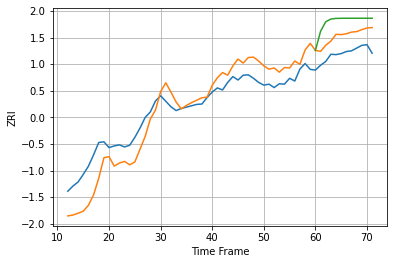

91367 55.321769529262745 52.58753285926364 94.53962018223113


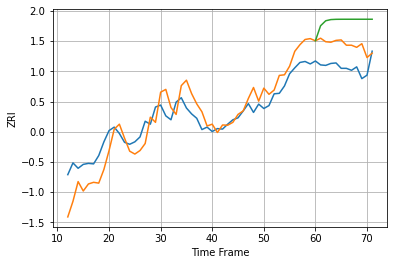

91505 35.679563521128316 47.59742627369567 93.39178936832876


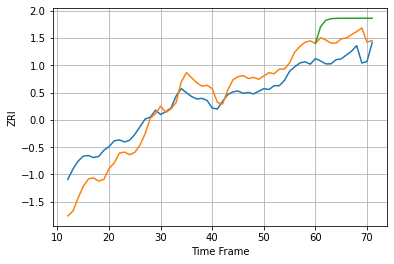

91601 61.73800067371945 67.99655921296602 125.23293971557688


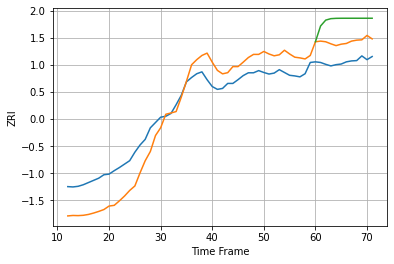

91730 71.13594226953647 64.7336370914448 131.45689883065694


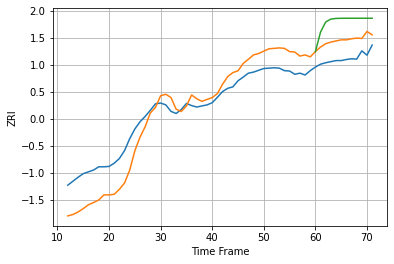

91764 56.60043729125152 51.62167873962066 102.92357609707739


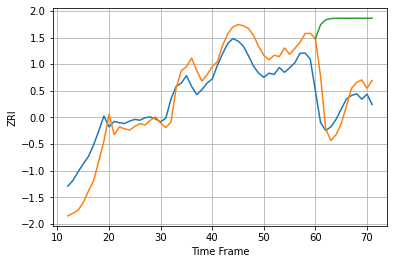

91766 47.951841994133986 57.420086773652386 213.2226069395567


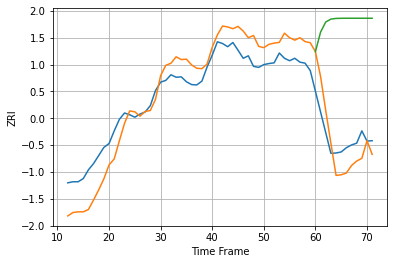

91776 61.07476246751934 67.69524172030252 334.6324579070738


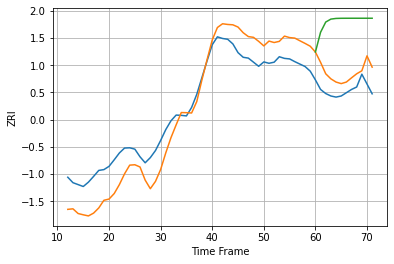

91801 84.13706615324315 71.12893417768612 250.14698279258536


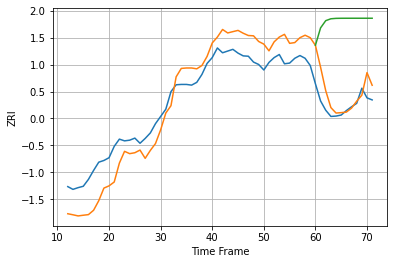

91803 63.12812783158184 53.09157995435873 244.3434882016165


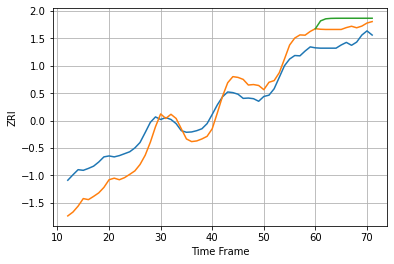

91913 59.733929156824146 50.48814937996117 75.95581848270278


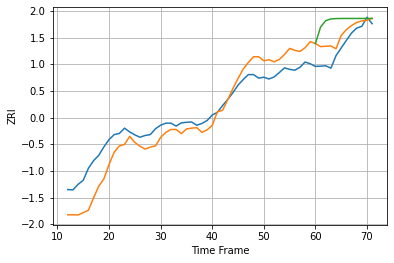

92008 61.18406695523905 46.85127612399828 96.81019041179707


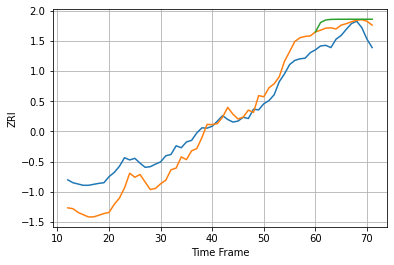

92101 61.62533416676295 43.98412364325491 59.384998268776535


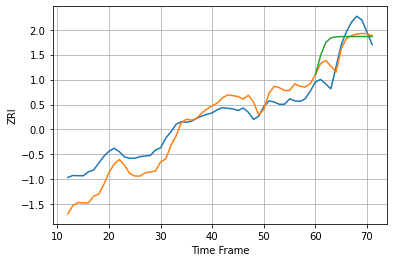

92103 59.374776005772105 47.56853485300043 83.91080169810404


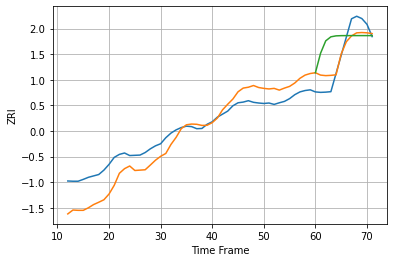

92104 75.02904527008486 56.838763900414655 127.31424849119117


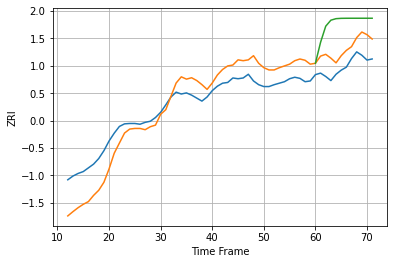

92108 51.84784951516221 48.72043563385483 117.30137366022113


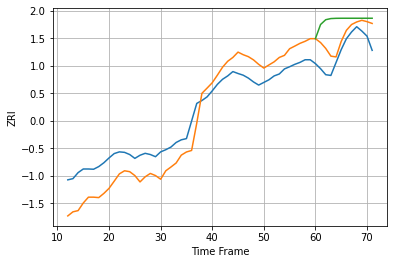

92117 91.19538616373374 72.464145678058 141.4904911444254


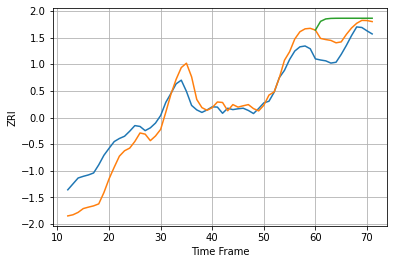

92122 64.47432888029266 59.12278805017168 107.63370787076644


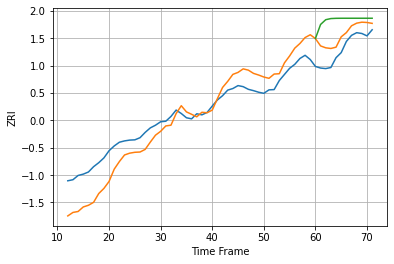

92123 70.0631722214666 59.78830756786571 118.50637372351717


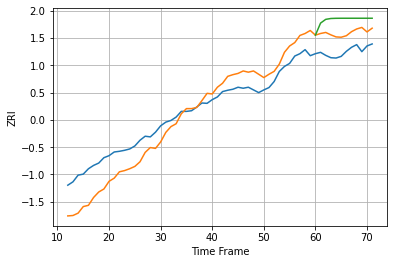

92126 57.43969818339896 56.58474637384711 95.22364820067014


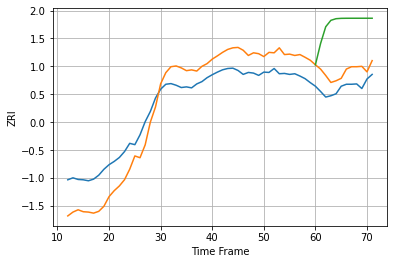

92128 69.65615897485021 51.27291577974977 193.52473949872905


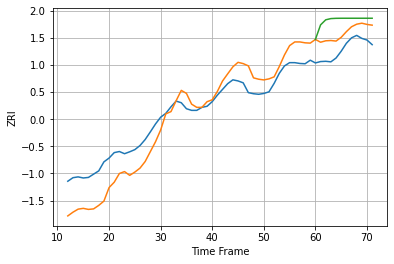

92130 74.89329981027127 62.837601014670085 111.25351043117499


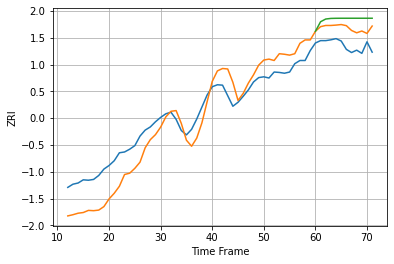

92410 51.81501400793348 44.87320232771287 66.71342482508405


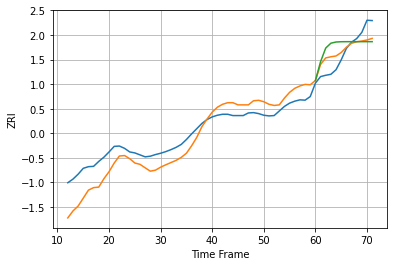

92507 47.674678490314065 37.39749380331204 56.288137880212815


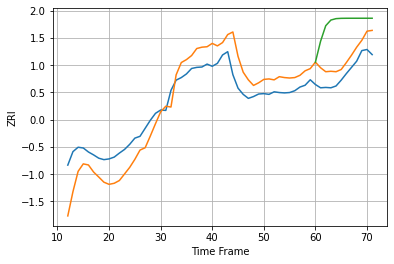

92602 56.00229334230707 45.015164246526965 137.270908267809


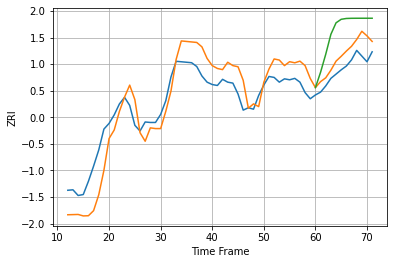

92603 44.319123057465724 30.857473399938538 81.8015032595269


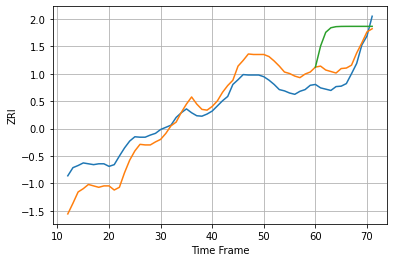

92612 42.3513655002313 34.28837739128796 103.82545746500449


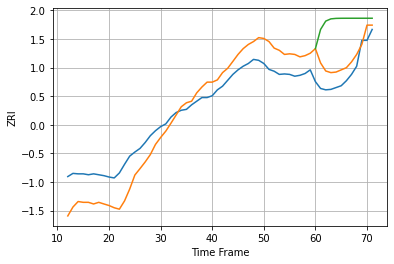

92618 47.924740659770904 38.155233340332344 117.33142328881998


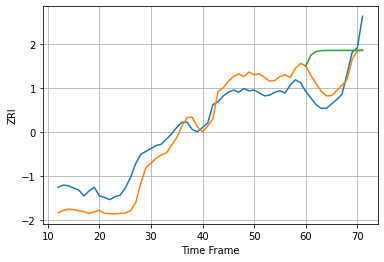

92620 24.022049547129715 23.36378232718447 57.18059586850633


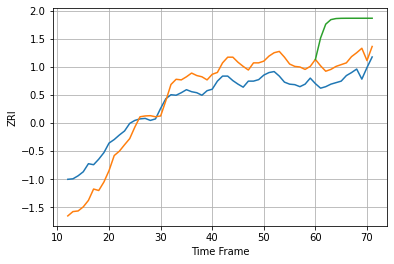

92626 39.358837483773634 35.68146548545288 108.30881682949092


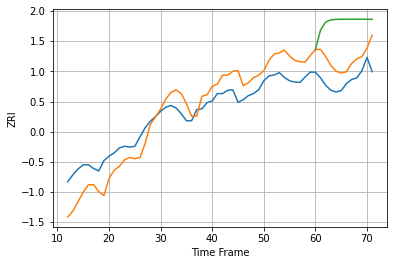

92627 46.30747671834013 53.781595288814486 140.65357867929686


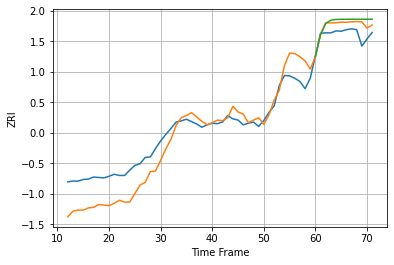

92647 48.0430428737227 25.679128042717462 33.06739648916259


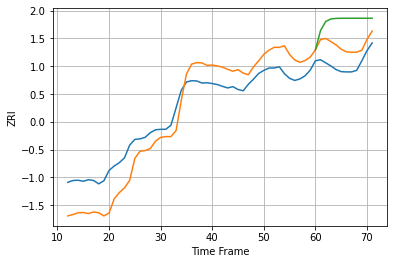

92648 87.13403211243362 73.51025988655563 166.81215262064947


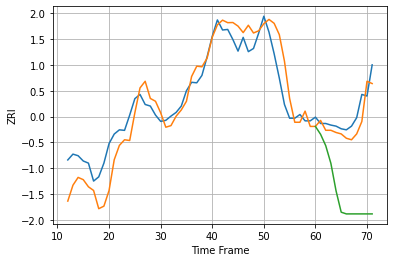

92651 38.764558678946095 24.77518096603392 161.82273331259947


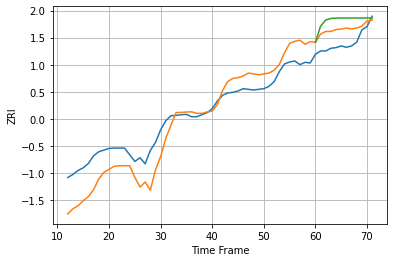

92656 59.67912344609532 44.271194168469215 70.85245651744627


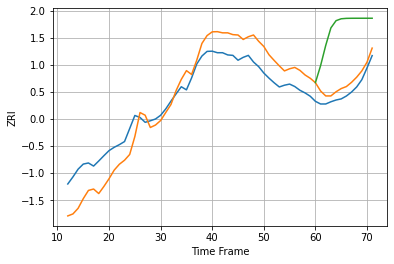

92660 95.75481326452022 45.9597701823261 284.0054580645397


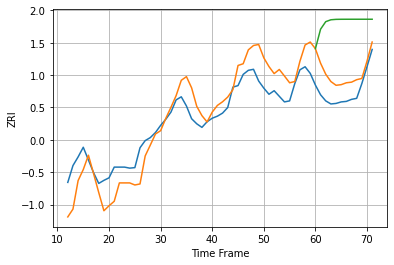

92663 40.87525517477625 41.10626411784806 138.3534789061737


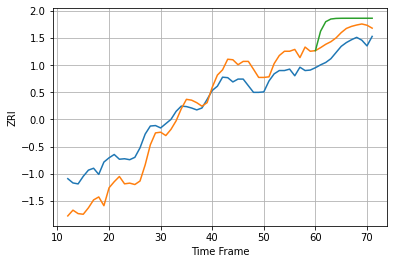

92672 45.09706673904636 32.758784249926705 59.65202913800846


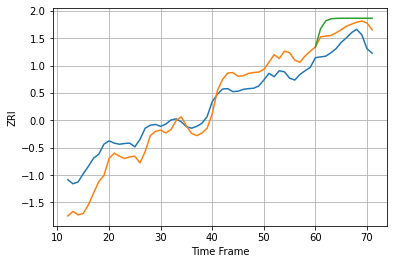

92673 50.372032338302745 44.371591272861224 68.97836122001067


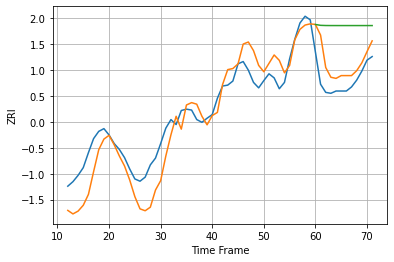

92677 46.200590029874604 46.334718707606605 122.72507988793333


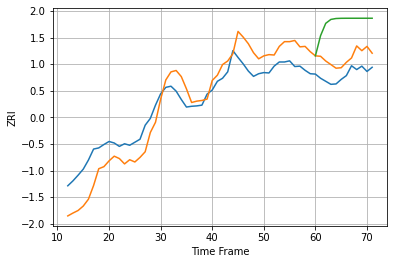

92691 54.53785080423156 47.39347651581073 139.4512084844576


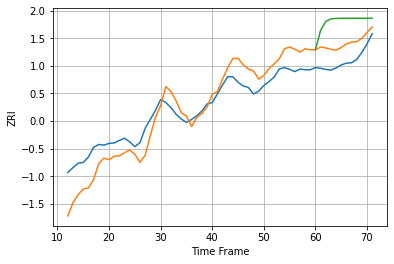

92692 49.99928984582391 48.21226110480786 108.3601580017958


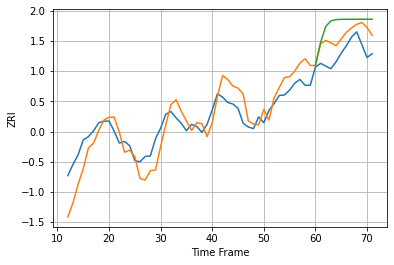

92707 32.261397042942534 35.05040091099614 58.3945502414535


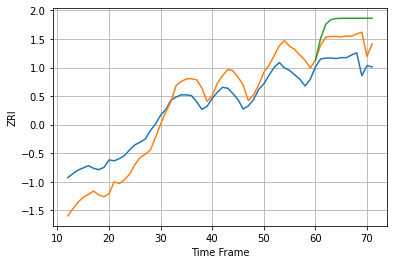

92780 46.51339086661041 49.42746598821361 88.08854570886747


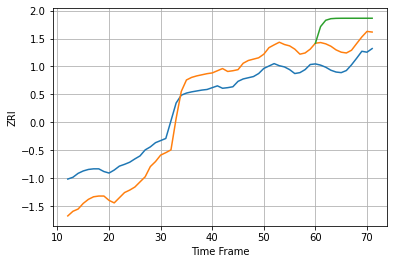

92782 74.89876787814637 65.24147271429077 143.31078601589152


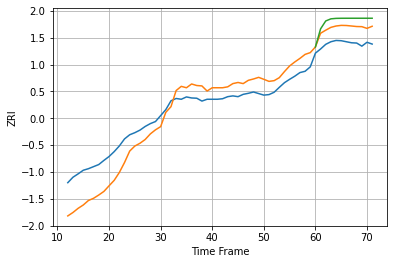

92805 72.80705081132841 59.421921514671325 88.41501821734754


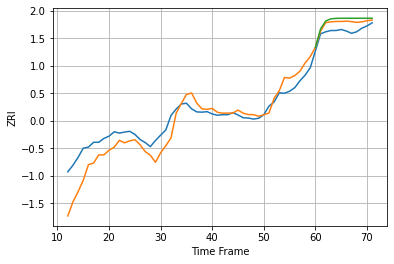

92806 58.423977594768495 30.402343033108156 41.046825558716066


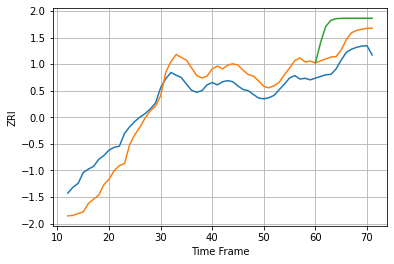

92832 51.208039484415515 42.780091624571575 96.32928552119976


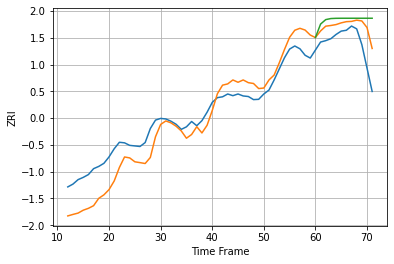

93001 69.13358695466283 73.0721853893918 105.89828839069123


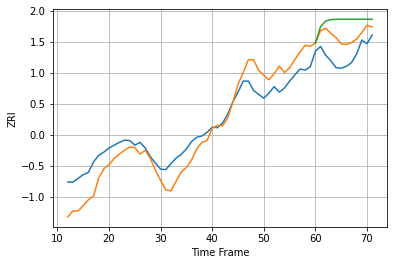

93010 40.09628127287566 43.591960533473724 75.76440209986765


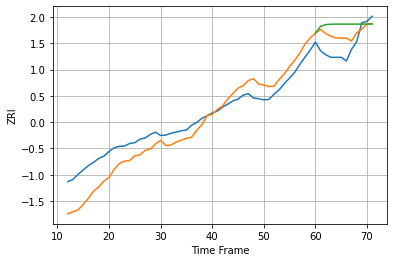

93030 46.910115397696764 43.075928347040346 67.66943480693558


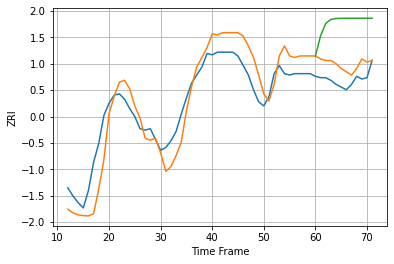

93304 15.66945999438753 12.4254278627023 42.839687312065095


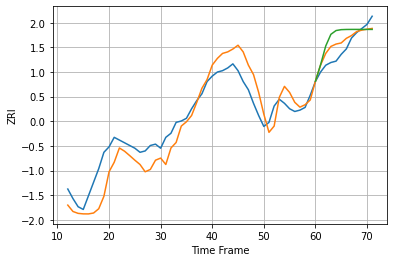

93305 13.344923423447183 7.228412965682451 12.413705481189123


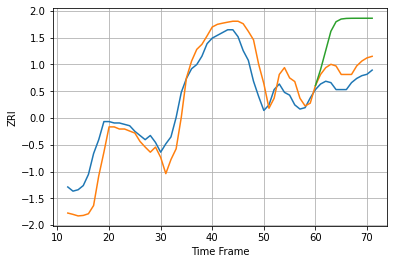

93307 14.983725291503657 10.454945998638342 39.0108044358937


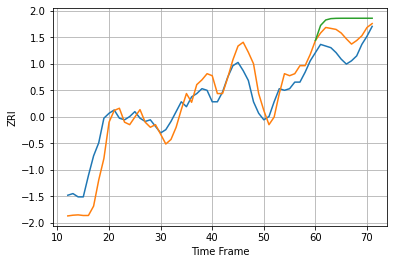

93308 11.256602352139602 10.454765498906468 18.701570386777746


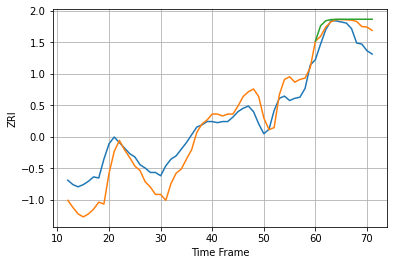

93309 16.917242016828766 12.747524718560978 17.029875485718573


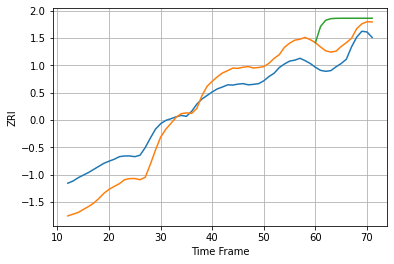

93906 88.60498718684211 69.6142410978156 153.16385812383515


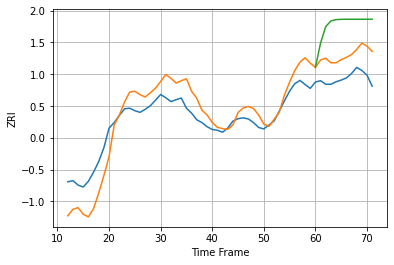

94010 67.38302303793992 84.33882580971729 197.331653521039


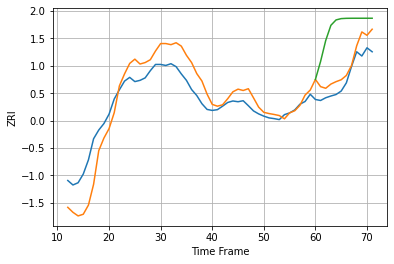

94025 76.12782672832964 57.53463285471599 207.9609021280135


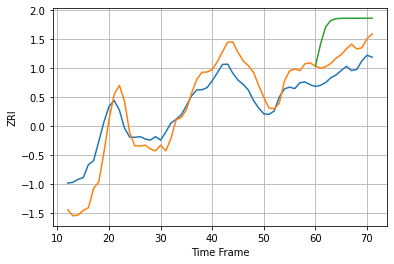

94040 86.80816818158904 78.842329412357 201.52475906847621


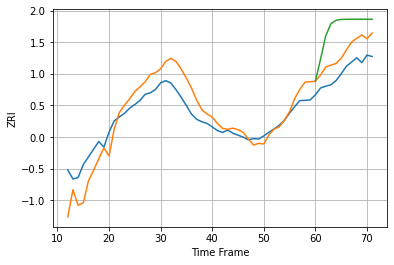

94061 69.83454513086093 77.51377057030712 183.63556212678196


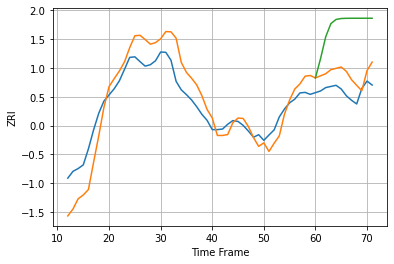

94066 70.63054132374955 62.21325579834078 229.97601597850738


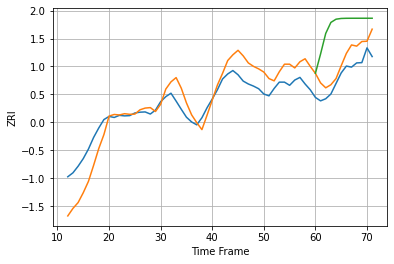

94085 68.65607518828088 63.498590316858454 190.50616527501802


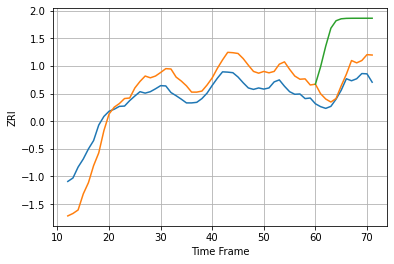

94086 67.08525644588266 51.51982789793882 212.0685704149895


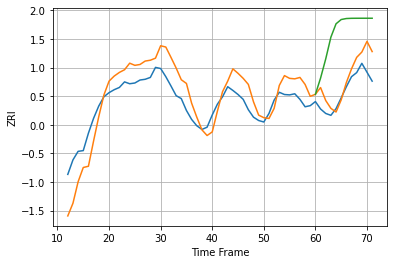

94087 52.32567798717845 42.628579091618846 161.7834867021657


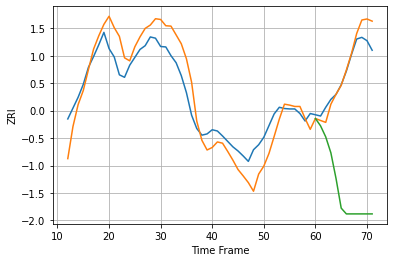

94103 49.83334542896665 30.526952444325463 302.7571898422639


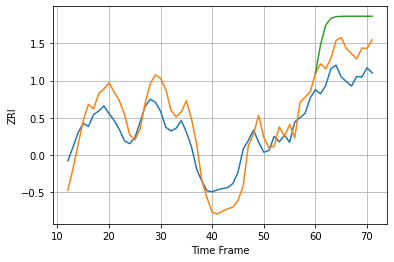

94105 44.65945914277604 58.66809529293709 122.83008599828574


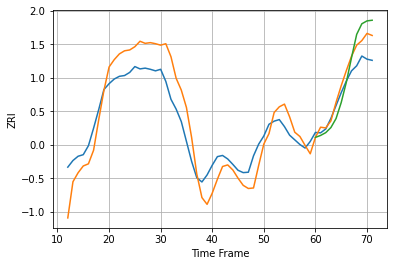

94107 56.64013134534116 36.2026210537354 55.75336583543643


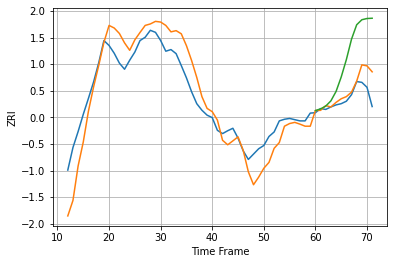

94109 50.7030925573057 31.89630916693045 112.30443699906198


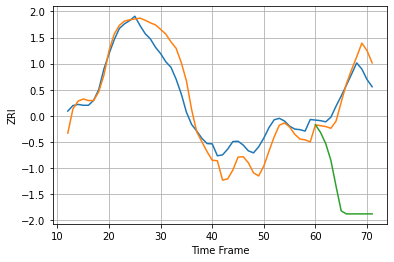

94110 58.184838637277174 50.62605905883561 367.2397143199281


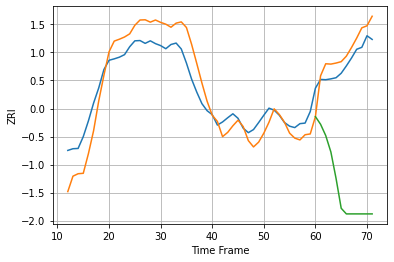

94115 70.81745846902619 56.057695261948346 461.5819753202634


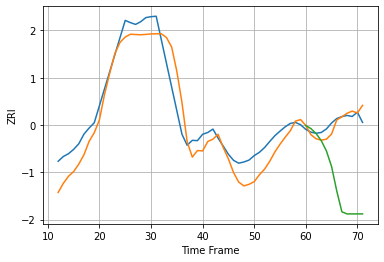

94158 122.10060125766523 50.14275558755844 455.2500648824509


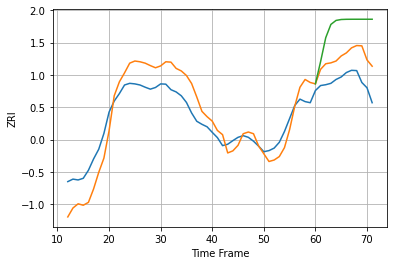

94401 69.62473782523173 86.73484745543632 200.11187465097396


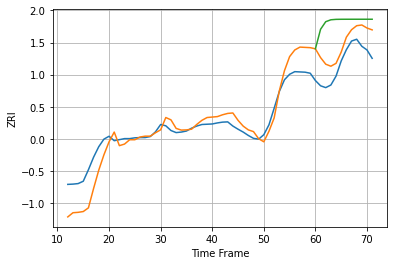

94403 57.47924560359508 79.293347377677 166.55974690408524


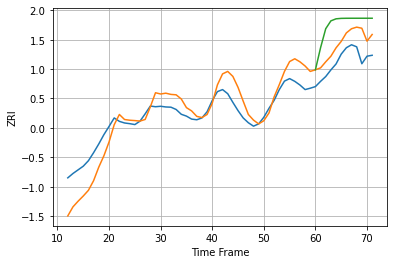

94404 73.40912243274957 80.57557969977503 163.12499576488014


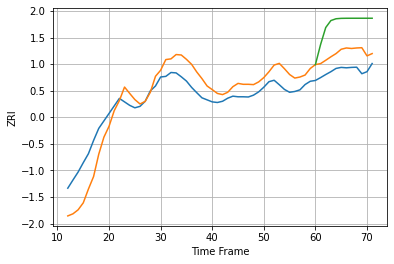

94501 88.94309124255408 84.53700696983546 229.4216982044305


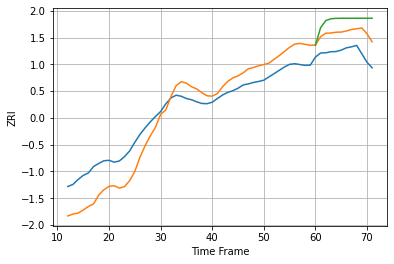

94509 98.48549586962204 97.67392708890853 160.46628246700283


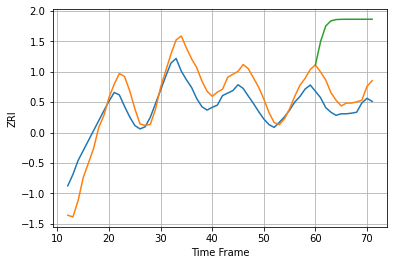

94530 63.675636034875936 56.82121769536964 269.6606599087152


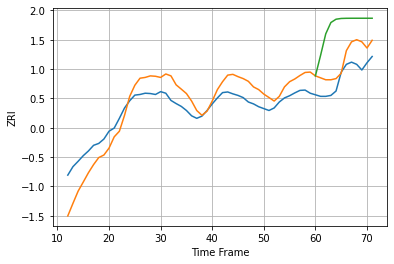

94538 55.71908232379513 57.15465915896775 163.5127087967839


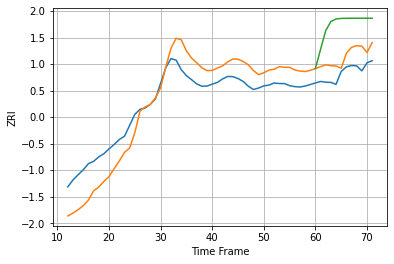

94541 106.64514633997531 86.65358060343057 252.05286997476404


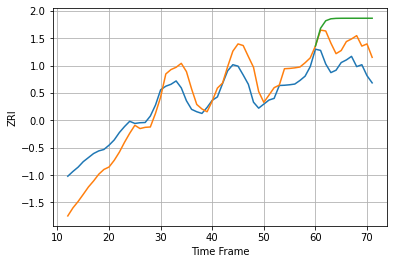

94549 79.92213634719684 96.76687950246803 191.47536555954363


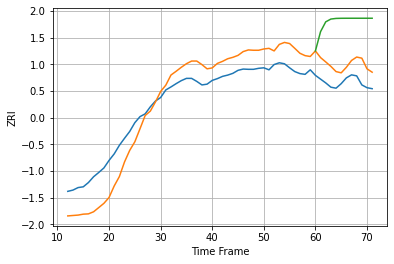

94565 83.08761460119577 75.59255377172335 242.49976635844345


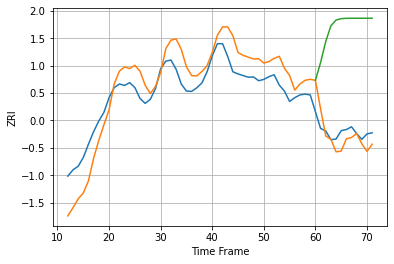

94568 79.01130828777714 54.40605192007459 384.28428555492314


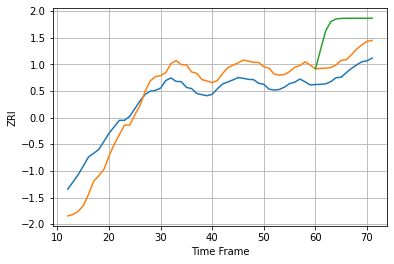

94603 104.5166712648256 85.77243374664158 261.75755501038384


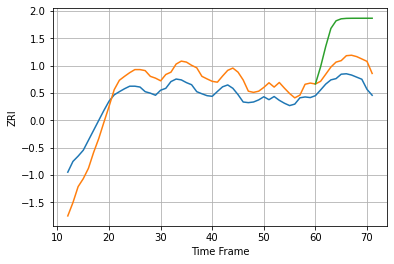

94608 86.711058036025 83.80887109668016 258.56571817170106


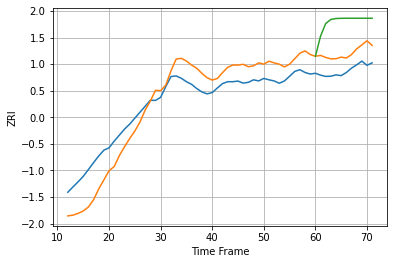

94621 125.75284310109191 113.55943273957523 309.5149251371658


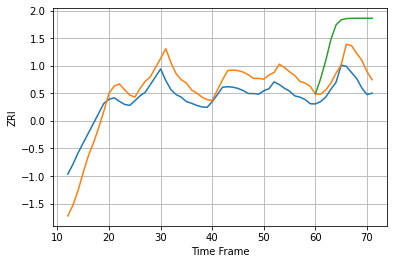

94703 87.11851525705472 82.1870057554997 254.18416669377712


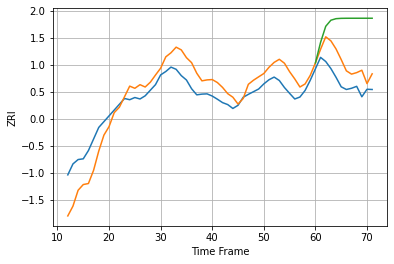

94801 75.80345331031187 81.71818718905679 245.69051681589522


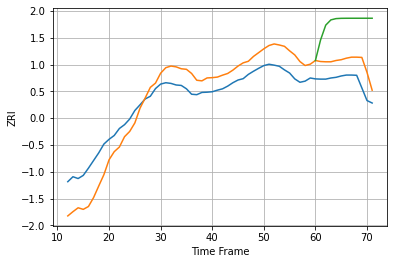

94806 89.33829927843371 86.66475915702244 266.9458341510286


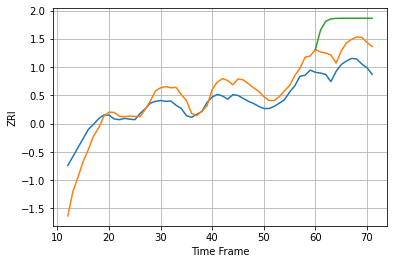

94901 56.20187338944498 81.78604733325452 177.82150543742253


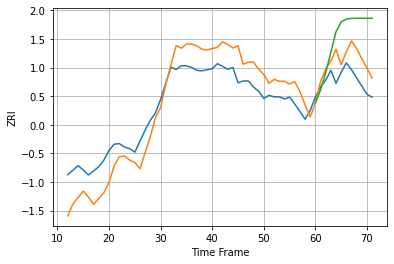

94903 82.82500702231584 77.69345015749748 189.42849508081005


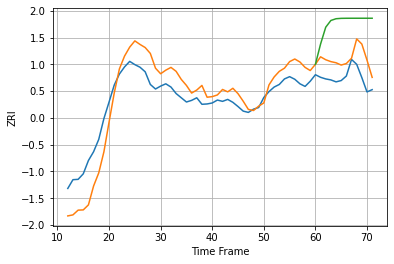

95008 60.62150380517996 62.36272533487874 169.67608273867458


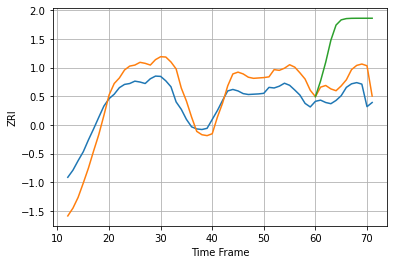

95014 65.91317486145317 58.053241236514666 217.32871702301597


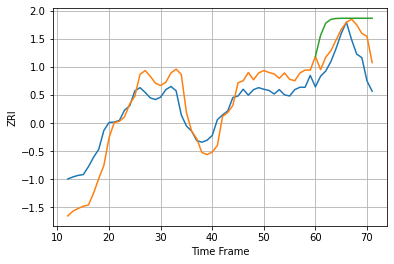

95050 50.07614195881243 56.75323994837878 104.30206167280308


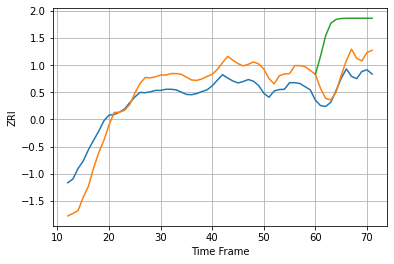

95051 66.23094112686576 57.34446598356953 204.57213485264526


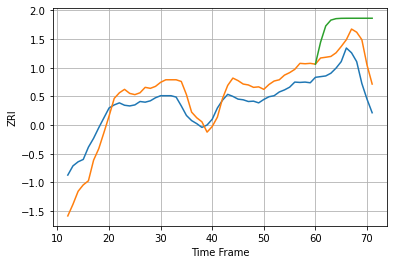

95112 51.18521322871127 71.01238049776889 157.82166629299223


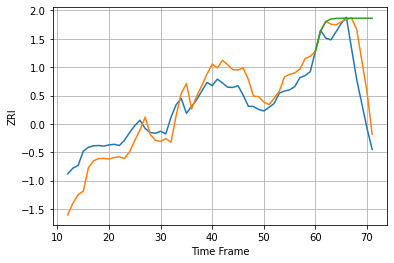

95116 59.77681112017235 83.68279024261984 199.24855174638884


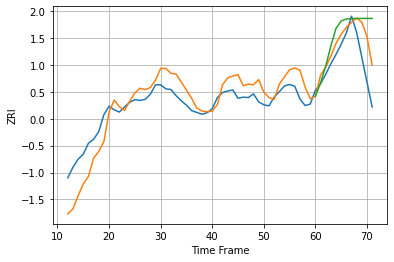

95117 48.07620045112074 60.30534780744485 98.89434540026677


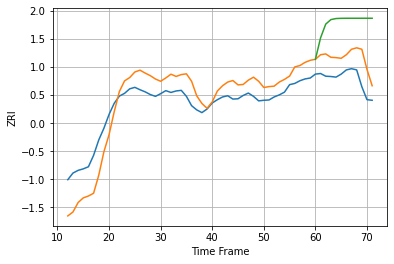

95123 63.69027080606838 72.40241591961812 191.74800148403142


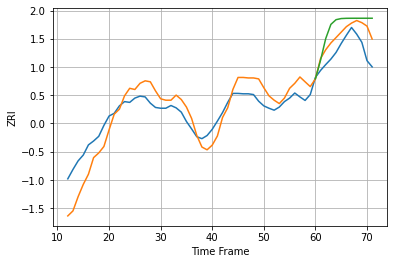

95128 43.07805912647096 44.46627695751563 70.42364450989068


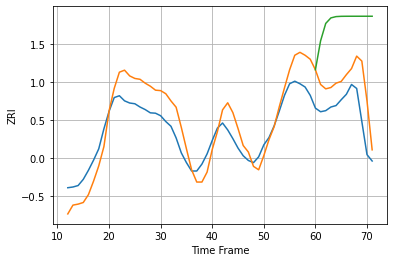

95134 56.97002953064239 87.91621852393956 256.1684809842471


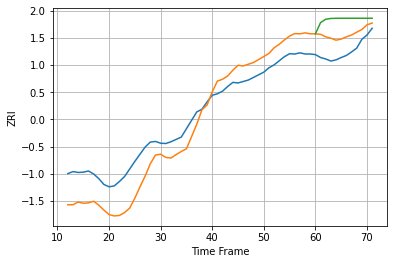

95207 75.65564282881162 61.06199924751988 110.59932328095006


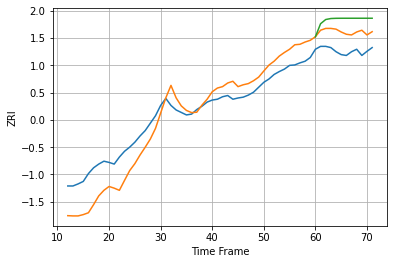

95608 47.70241840858459 45.919768871441775 74.89256013767047


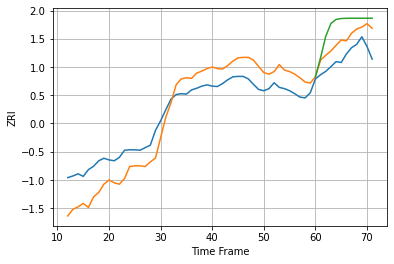

95678 50.116414078915746 41.49984676253247 77.2351881160369


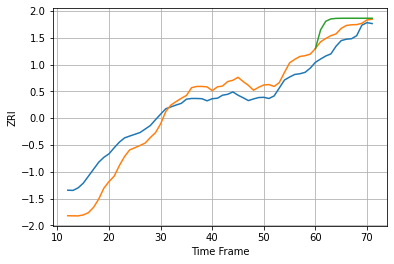

95816 77.66457512280121 54.78230510190685 95.81741673978931


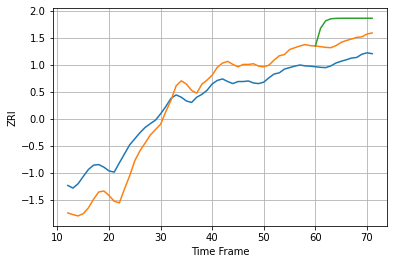

95826 72.42978080929541 66.5308394771711 136.35478946832123


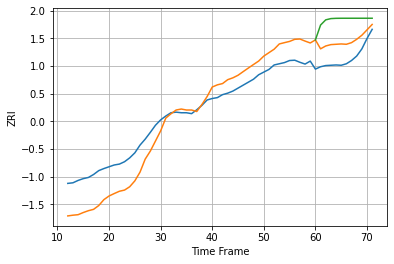

95831 70.78052937488562 62.526582920917285 130.5343636848623


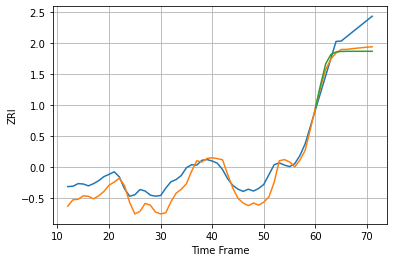

95928 34.25982990611126 44.495616591713606 51.76677993029812


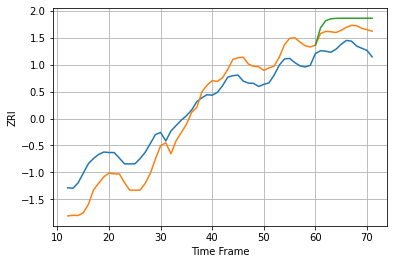

96150 82.55127412823828 70.79517291084788 109.42441386053264


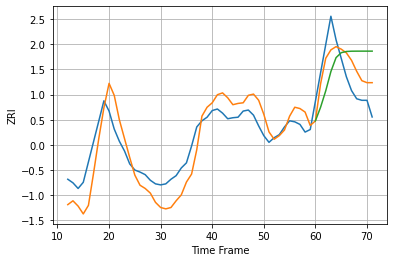

96826 38.18967713020167 43.875245359452485 81.11607700988044


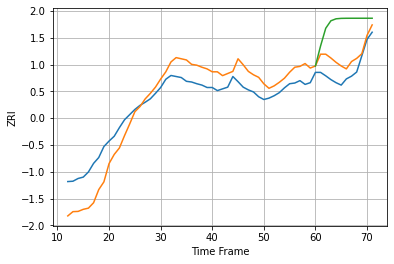

97030 57.53705663808864 43.363294753681245 138.07772316639165


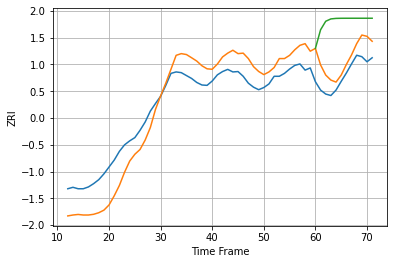

97035 59.056670551734 51.0918099589939 151.85498417959465


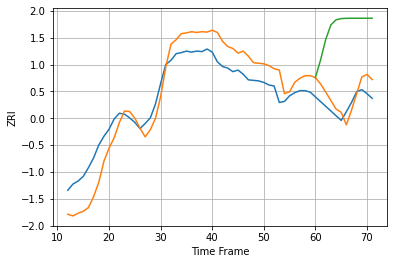

97062 40.74176069467746 26.53194469841514 150.80059548308944


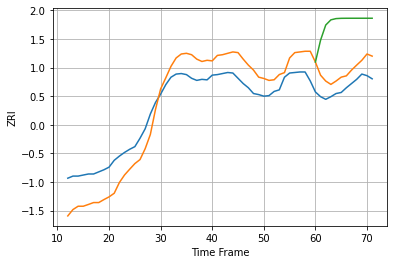

97070 42.35029106937594 34.40899910798991 122.18165397844378


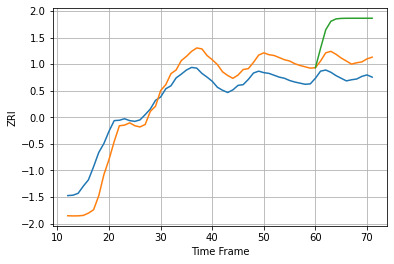

97124 51.50214757814261 46.095101295502964 140.16068616995895


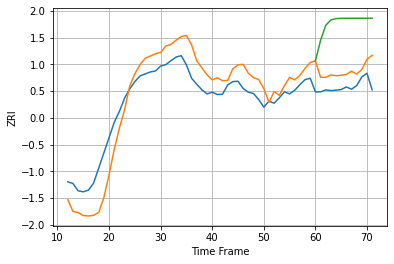

97209 61.777289937398535 55.34413704160025 192.220526026238


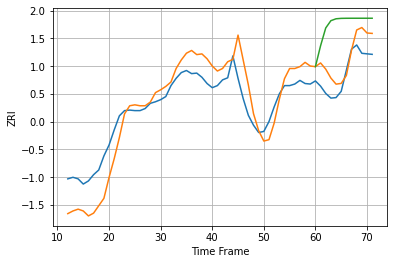

97214 41.89281734130625 34.01255562317164 98.85159658470845


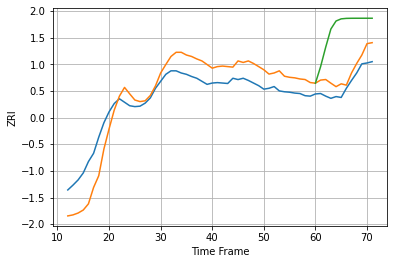

97229 44.93928030847263 29.978104863856853 128.36466880243336


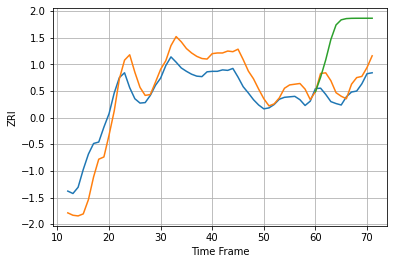

97239 42.28181432726763 26.502668167575155 128.4730837272066


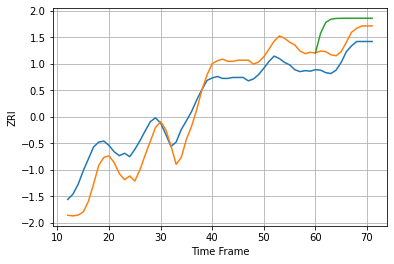

97401 42.44164323780684 32.202038825899365 74.61400688860648


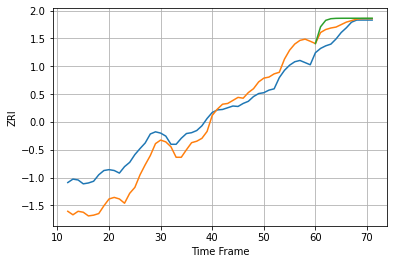

97402 48.60102034763223 22.36070993312918 34.21266342738011


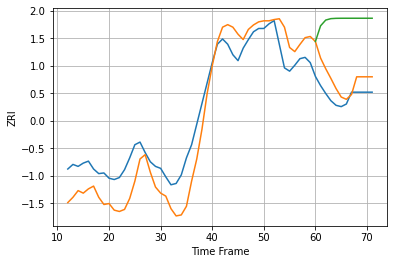

97477 38.665087963615846 29.259661448168554 113.75167305746474


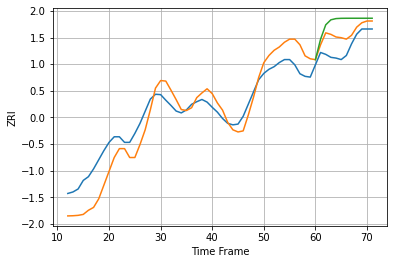

97501 50.79273627090954 39.14023441505364 70.9120160530912


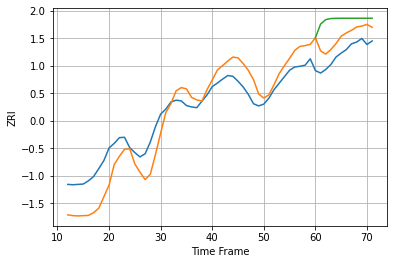

98004 58.04609104050775 50.71061378699066 97.7437456870419


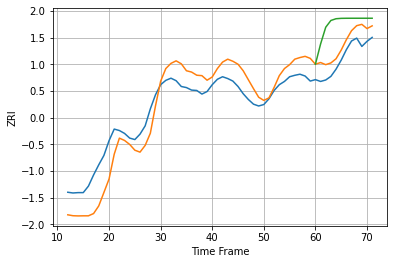

98005 54.62798930208457 38.89614358456971 99.3343270957768


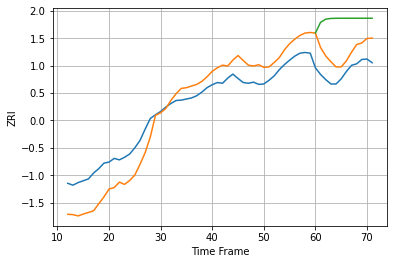

98012 57.39131123130353 57.81397450646664 141.62423869054973


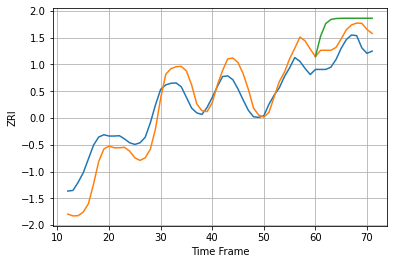

98029 60.7082693810964 51.174328622583346 100.05385338064296


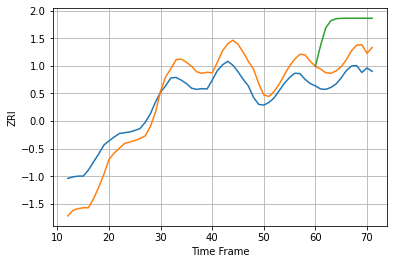

98034 53.70132989039863 46.83667327510245 138.22815103276804


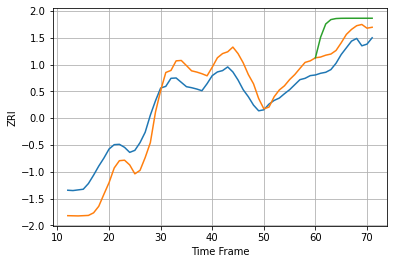

98052 61.54914147926242 44.69474355030188 99.54019804613542


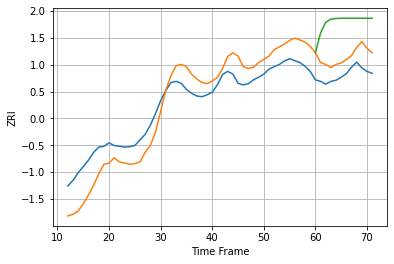

98056 53.358047778707025 49.41482376948595 138.1044041198007


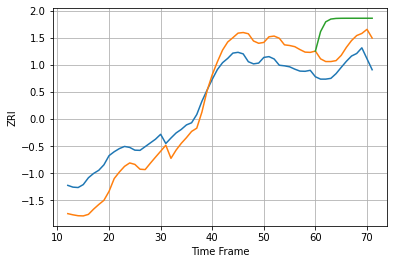

98101 111.42781696101001 102.31930482511079 232.71511565752334


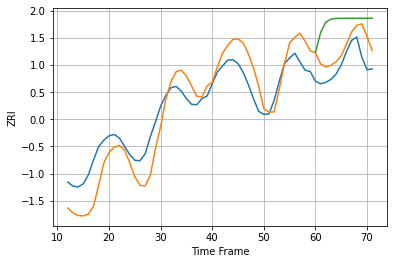

98102 50.46575567846693 45.31030852662802 103.70332042075165


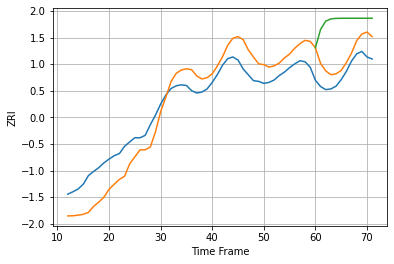

98103 61.20817829604967 53.90541160219729 151.28331307288656


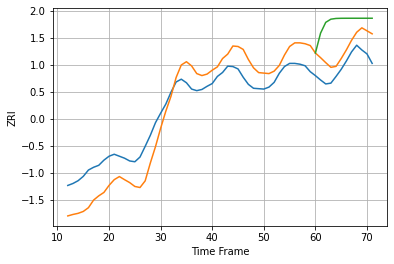

98105 57.06114570045938 47.6572403902713 114.54673870102927


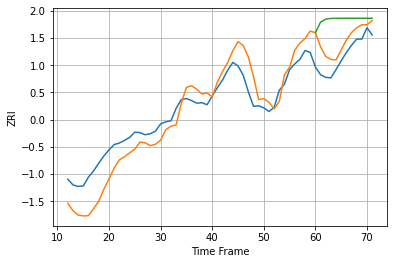

98107 37.54212579089108 34.513244217128126 75.85124147318923


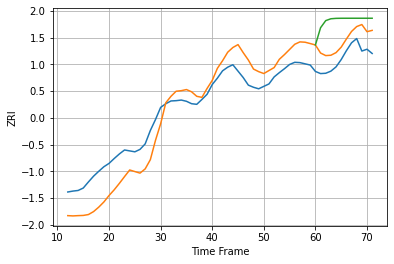

98109 68.87095105413933 59.972344521411614 126.27083129078483


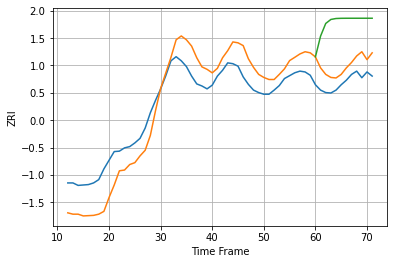

98115 54.96169444310215 44.211339074539154 145.06034626769483


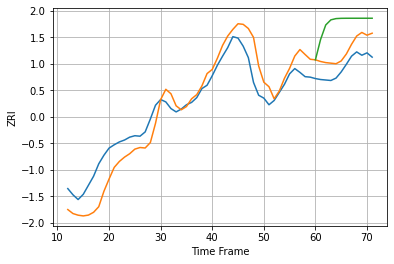

98119 40.921178121814776 35.90623501709587 93.58640546874682


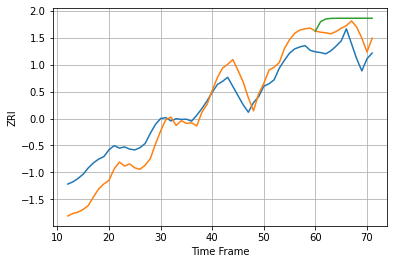

98121 78.39279432254625 81.01509602473287 132.77980736365777


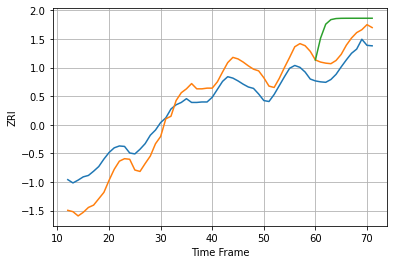

98122 43.65668785312331 35.808612623897446 88.62233743418835


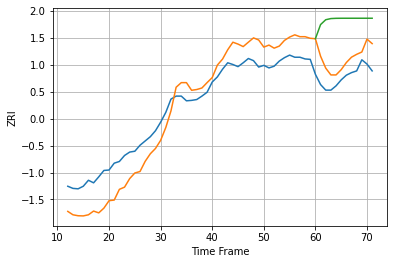

98133 51.64028462220845 48.31847855734309 133.22511984255664


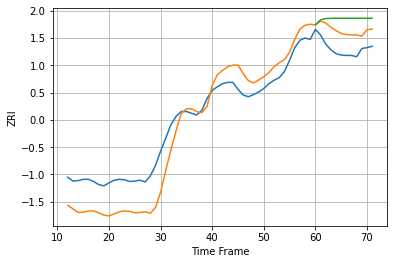

98201 53.55590800457694 43.39639208250764 70.64370752334881


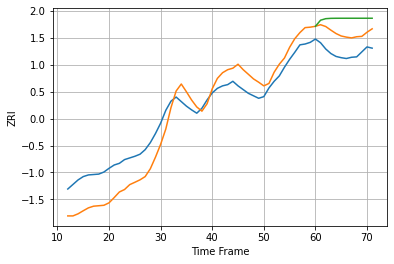

98203 51.23056583076068 47.27339930453637 80.44318656270192


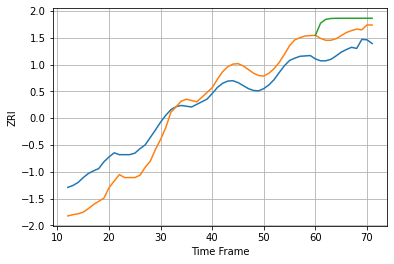

98204 54.199739272813275 48.72250505560889 84.97966539458203


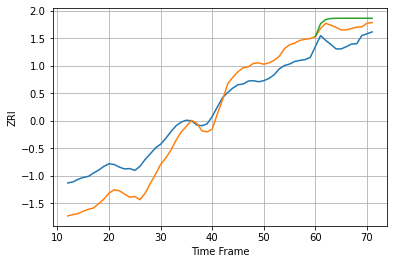

98405 59.65907047599023 40.71023025758753 60.967991088870015


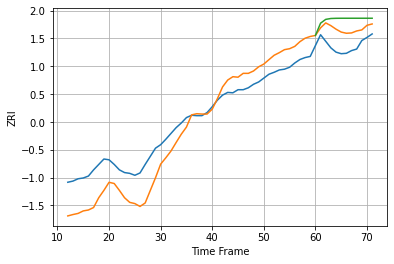

98409 57.14473213847666 43.34247254701789 68.01031777198926


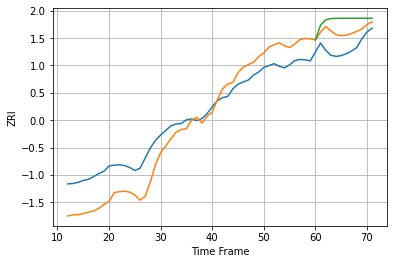

98444 58.10622129473141 44.030132988969655 73.64628615907553


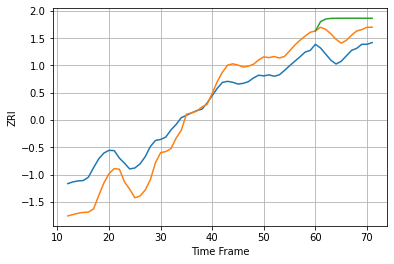

98466 62.582696719693914 56.16032476318214 97.26074264159863


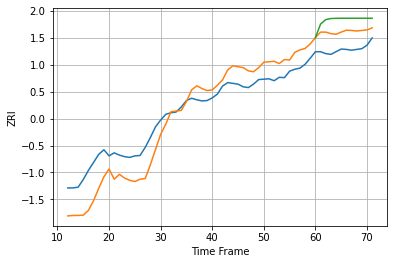

98498 53.00746581051915 46.86157202637897 77.42155640015353


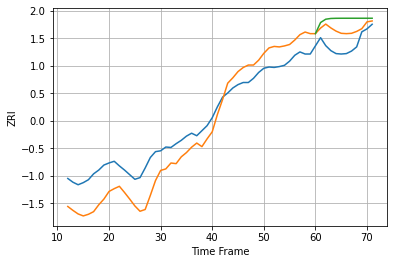

98499 54.63118589371634 38.85002877422965 62.09636606380502


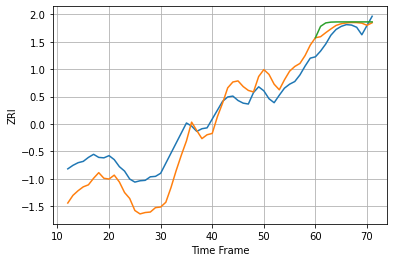

99207 48.382003880573095 20.392813889483225 28.728989780805087


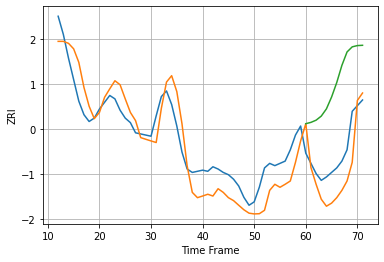

99501 18.95769226738656 23.583568791390142 60.69544852480637


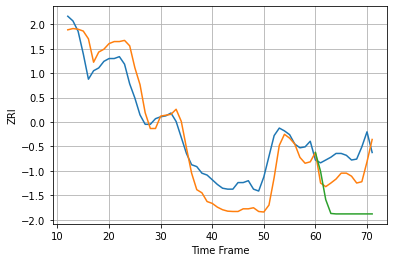

99504 22.74086750476872 24.422900039882855 58.71354518046496


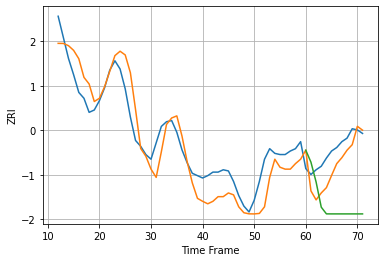

99508 17.993106209554433 16.77456714447096 52.55571802928387


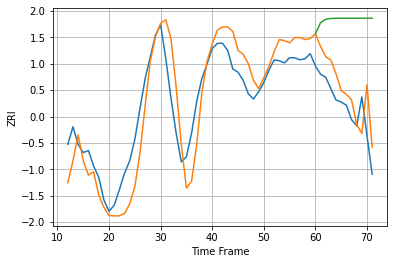

99654 25.65382861727644 26.599544121121014 88.29709301878441


In [14]:
time_train = list(range(SPLIT));
time_test = list(range(SPLIT, len(single_city_series)))

score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};

for zip_num in multi_4:
    test = multi_data[multi_data["zip"] == zip_num];
    city_mean = cities_stats[zip_num]["mean"];
    city_std = cities_stats[zip_num]["std"];
    
    single_city_series = (np.array(test["zri"]) - city_mean)/city_std;
    
    forecast = []
    results = []
    for time in range(len(single_city_series) - WINDOW_SIZE):
        forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE, np.newaxis, np.newaxis]))

    #print(forecast)

    # forecast = forecast[SPLIT - WINDOW_SIZE:]
    # print(np.array(forecast).shape)
    results = np.array(forecast)[:, -1, 0]
    actual = single_city_series[WINDOW_SIZE:]
    time_actual = range(WINDOW_SIZE, len(single_city_series));

    pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
    for time in range(SPLIT, len(single_city_series)):
        # print(model.predict(pure_forecast[-WINDOW_SIZE:][np.newaxis]))
        pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[..., np.newaxis, np.newaxis]))[-1,0])
    pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);
    
    M_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * city_std;
    M_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * city_std;
    M_pure = mean_squared_error(actual[-TEST_LENGTH:], pure_forecast[-TEST_LENGTH:])**0.5 * city_std;
    forecast = list(np.array(pure_forecast[-TEST_LENGTH:]) * city_std + city_mean);
    
    plot_series(time_actual, actual);
    plot_series(time_actual, results);
    plot_series(time_test, pure_forecast);
    plt.show();
    
    score_dict["zip"].append(zip_num);
    score_dict["RMSE_train"].append(M_train);
    score_dict["RMSE_test"].append(M_test);
    score_dict["RMSE_pure"].append(M_pure);
    score_dict["forecast"].append(forecast);
    print(zip_num, M_train, M_test, M_pure)


In [15]:
print(len(score_dict["RMSE_pure"]), sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]),
      sum(score_dict["RMSE_pure"])/len(score_dict["RMSE_pure"]));

242 58.36429268824796 165.32312849135872


In [16]:
test = pd.DataFrame(score_dict)
test.to_csv('NN_4_batch.csv', index = False)

In [17]:
# NN_1_summary = pd.read_csv('./NN_1_summary.csv', index_col = 0);


In [18]:
# NN_1_summary[NN_1_summary.index.isin(score_dict["zip"])]["RMSE_pure"].mean()

### Then, we need to tune the hyperparameters...

#### Starting from here, we need a train/validation/test split

#### Wrapping to GridSearchCV in sklearn...

Plan: use the `tf.keras.wrappers.scikit_learn.KerasRegressor` wrapper

https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

In [19]:
# model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')